In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

import sys
sys.path.append('../src')

import plot_correlation as pc

%load_ext autoreload
%autoreload 2

%run insights.py
%run plot.py

sns.set()

In [2]:
# Create spark session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [6]:
# Load all datasets
metrics = spark.read.load('../data/dataset_metrics.parquet').toPandas()
score_metrics = spark.read.load('../data/score_metrics.parquet').toPandas().set_index('score')
comments = spark.read.load('../data/sample.parquet')
comments.registerTempTable("comments")
daily_metrics = spark.read.load('../data/daily_metrics.parquet').toPandas().set_index('created')
subreddit_agreement = spark.read.load('../data/subreddit_agreement.parquet').toPandas().set_index('subreddit')
daily_agreement = spark.read.load('../data/daily_agreement.parquet').toPandas().set_index('created')
lda_result_one_w_df = spark.read.load('../data/oneW_oneT_lda_result.parquet').toPandas().set_index('post_id')
lda_result_three_w_df = spark.read.load('../data/threeW_twoT_lda_result.parquet').toPandas().set_index('post_id')
nlp_metrics_full = spark.read.load('../data/daily_nlp_metrics_full.parquet/')

### Dataset Description

##### Source

Our dataset contains all the comments available on Reddit from December 2005 to March 2017. It was firstly parsed and publicly maide avaible by a reddit user by the name of u/Stuck_in_the_Matrix [on 2015](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/). Two years later, the user u/Dewarim provided torrents for [an updated version of the dataset](https://www.reddit.com/r/datasets/comments/65o7py/updated_reddit_comment_dataset_as_torrents/) which also includes all the comments from 2015 up to March 2017. This updated version is the one used as our dataset.


##### Overview & Schema

Before diving into the information we extracted from the dataset, let's look at the types of values that are contained within it. 

In [7]:
comments.printSchema()

root
 |-- distinguished: string (nullable = true)
 |-- retrieved_on: string (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- edited: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- flair_text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = true)
 |-- downs: integer (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_context: string (nullable = true)
 |-- flair_css_class: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- body: string (nullable = true)
 |-- archived: boolea

In the context of our data collection, we specifically looked at the following types,

* `created_utc` to be able to date the comment
* `author`, `subreddit_id` and `link_id` to aggregate the comments per author, topic or post.
* `ups`, `downs` and `score` to represent the high-level sentiment of the community with regards to the comment.
* `controversiality`, which is a pre-computed metric of controversiality.
* `body` in order to extract topics and sentiment from the text itself.

We will dive successively into each of these topics in this notebook. But first, let's start with the basic information about the dataset, i.e. its size and range of dates.

In [8]:
insights_comments(metrics)

> The dataset contains a total of **3,092,028,928** comments ranging from **12/12/2005** to **03/31/2017**.

An important thing to note given the schema seen above is that we do not have access to the content of the posts, only the comments. We do however have access to the id of the post (`link_id`) on which the comments are written. We can use this information, for instance to group comments that related to the same post. It is also possible to calculate the total number of posts (with at least one reply) on Reddit.

In [9]:
insights_posts(metrics)

> There is a total of **204,469,276** posts on Reddit with at least one reply.

Moreover, it is also important to understand the notion of *thread* in Reddit comments. Each comment has a parent, defined by `parent_id`. It means that comments might be at different depth. Top-level comments (which have depth 0 and answer the original post directly) will have the post id as `parent_id`. Lower-level comments on the other hand, have another comment as parent. We can use this information to extract the number of top-level comments and lower-level comments from the dataset.

In [10]:
insights_comments_levels(metrics)

> Out of all the comments, **1,223,260,504** (**39.56%** of the dataset) are top-level comments. This makes an average of **5.98** top-level comments per post. The other **1,868,768,424** (**60.44%**) are replies to other comments.

##### Deleted and Removed Comments

Some comments are marked as `[deleted]` or `[removed]`. According to [this Reddit post](https://www.reddit.com/r/help/comments/38cjx8/user_delete_vs_mod_delete_how_to_tell_the/), the `[deleted]` means that the comment was simply deleted by its author. There are a few reasons to do that, for instance to hide a negative comment from one's history, or to avoid getting more downvotes that we already have and prevent one's karma from getting too low. 

In [11]:
insights_removed(metrics)

> A total of **186,592,666** comments were deleted by their authors, which is **6.03%** of the dataset.

On the other hand, `[removed]` indicates comments that were removed from the moderation team of the subreddit that the comment belongs to. This can also indicate potential toxic or vulgar comments, but it is not very reliable as it can also include off-topic comments.

In [12]:
insights_deleted(metrics)

> A total of **25,544,034** comments were removed by the moderation teams, which is **0.83%** of the dataset.

##### Score

On Reddit, people can *upvote* (`ups` in the dataset) posts or comments that they agree with, and *downvote* (`downs`) comments with which they do not agree. These values are then used to calculate a `score` metric with a simple formula `ups - downs`. 

Unfortunately for us, even though the dataset sometimes include `ups` and `downs` attributes, their value seems to be completely wrong. In fact, there is no instance where `downs` is different than 0.

In [13]:
spark.sql("""SELECT downs, COUNT(*) FROM comments GROUP BY downs""").show()

+-----+--------+
|downs|count(1)|
+-----+--------+
| null| 2637603|
|    0| 3543945|
+-----+--------+



This is very problematic for us, as we were hoping to come up with our own formula for measuring polarity based on the number of upvotes and downvotes of a comment. For now, we will have to restrict ourselves to only using `score`. Let's see what the range of `score` is.

In [14]:
insights_score(score_metrics)

> The highest score of all the dataset is **88,484** and the lowest score is **-12,063**.

Now, let's look at the distribution of `score`. Since it can be negative, we will have to plot the positive and negative scores separately. (and it is required for log-log plots).

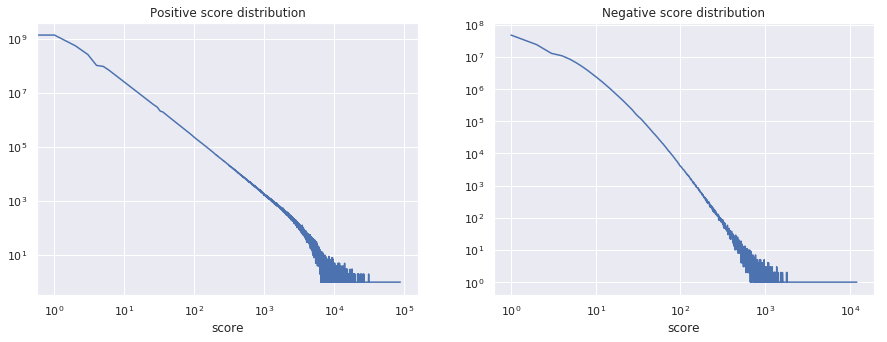

In [15]:
plot_scores(score_metrics)

We can see that the positive score seems to follow a nice power law. We will need to improve / confirm that later on with a cumulative and smoothed out plots, but this will require additional computations which we do not have time to run as of yet. Interestingly enough, the negative score is not as straight and indicates that the negative scores do not follow the same power law as the positive scores do. 

### Evolution over Time

Now, our goal was to understand how the Reddit community has evolved in terms of controversiality, polarity and aggressivity over time. Our first step towards understanding such evolution was to visualize how the above metrics (as well as additional ones) have changed over the years.

##### General Reddit Traffic

Let's first see how the overall traffic has evolved over Reddit. Because the daily data can be very noisy (in blue below), we perform a 60-day window average for all of the following metrics (in orange). 

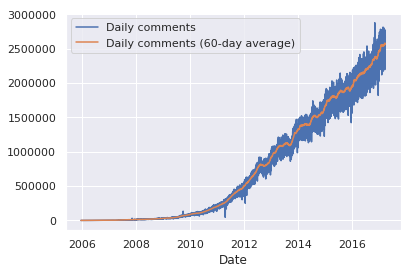

In [16]:
plot_daily_metric(daily_metrics, "count_of_comments")

We can see here that the number of comments on Reddit, after a slow start between 2005 and 2009, has ever since been steadily increasing. Moreover, the curve is similar to the **daily active users** which we can see below.

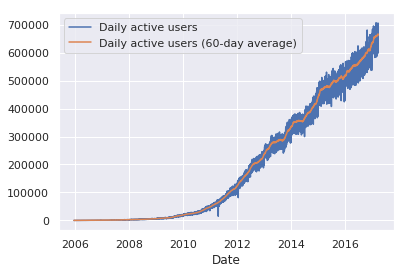

In [17]:
plot_daily_metric(daily_metrics, "count_of_users")

### Polarity & Controversiality Metrics

Now, we would like to narrow our focus down to the idea of measuring divisiveness on Reddit. Even before diving into the text of the comments, there are some high-level metrics that we can try to compute based on some of the attributes, for instance the `score`. Here is a list of such metrics and how they changed in time.

##### Controversiality

As we can see in the dataset schema, Reddit does provide a binary flag `controversiality` for each of the comments. If we trust [Koooooj
's explanation](https://www.reddit.com/r/NoStupidQuestions/comments/3xmlh8/what_does_something_being_labeled_controversial/cy5yk1m), as well as Reddit's [announcement of the feature](https://www.reddit.com/r/announcements/comments/293oqs/new_reddit_features_controversial_indicator_for/) a comment is flagged controversial when both down and up votes are high but their difference gets under a certain undisclosed threshold. In other words, Reddit will consider something to be controversial whenever it receives a high similar amount of down and up votes, which means that the community was evenly polarized by the comment's content.

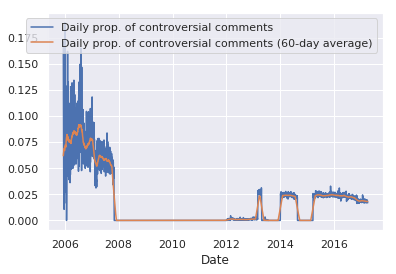

In [18]:
plot_daily_metric(daily_metrics, "prop_of_controversial")

Unfortunately, as we can see here, the `controversiality` metric is set to `0` to all the posts between 2008 and 2012, and there are two more gaps after that. Based on this, it will not be a very valuable metric over the long term. We might still be able to use it from 2015 onward, as it seems to be working properly there.

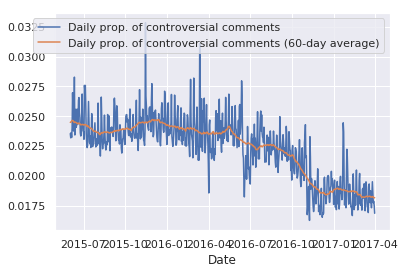

In [19]:
plot_daily_metric(daily_metrics[daily_metrics.index > dt.date(2015, 6, 1)], "prop_of_controversial")

##### Deletion and Moderation

Another indirect metric that could be interesting to look at is the number of comments that were removed from the moderation. Such comments are identifiable by the fact that their body has changed to `[removed]`. This also means that we do not have access to the previous content of such messages. We do not believe that this metric is meaningful enough on its own, but it could be interesting to use it as a supplement to another analysis. Again, there are many factors that could contribute to a post being removed, for instance if it breaks the rules of a subreddit.

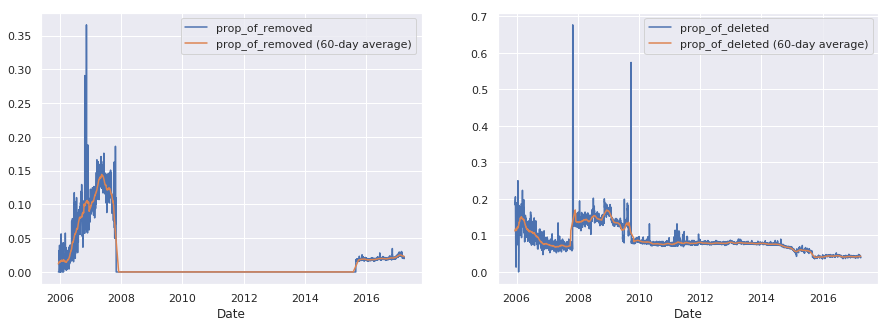

In [20]:
plot_daily_metrics(daily_metrics, "prop_of_removed", "prop_of_deleted")

These plots seem to indicate that there is some inconsistencies in how to dataset handles `[removed]` and `[deleted]`, which contradicts our original assumption. Moreover, the date after which `[removed]` is consistently 0 seem to coincide with the big spike seen in the number of `[deleted]`. One possible explanation would be that after this date, all `[removed]` were actually changed to `[deleted]`.

##### Agreement Factor

Now for a first metric that we computed by hand, the agreement factor is actually something fairly easy to compute. It basically takes the ratio of comments with positive score over the total number of comments. The intuition is that in controversial topics and/or echo-chamber situations, more posts are expected to be downvoted by the dominant community. 

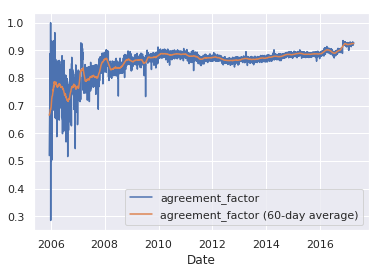

In [21]:
plot_daily_metric(daily_agreement, 'agreement_factor')

This result contradicts what we were expecting, as we can see that the *agreement factor* has actually been increasing relatively steadily. This could however hint at the fact that Reddit has become more of an echo chamber over time. Of course, this might not be the only factor, and there might be several biases related to this metric. For instance, a post with negative score does not necessarily indicate a divergence of opinion, it could simply be a post that does not respect the rules of a community, someone providing wrong information or a comment that does not add anything to the dicussion like "lol" or "ok".

We can also see on this graph that there is a spike around the beginning of 2017, let's zoom in to see exactly where.

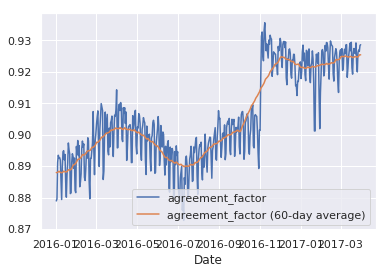

In [22]:
plot_daily_metric(daily_agreement[daily_agreement.index > dt.date(2016, 1, 1)], 'agreement_factor')

This spike in agreement seems to be located at the beginning of November. This exactly matches the moment at which the results of Trump's election came out. Is this a coincidence, or is there some underlying bias that we failed to take into account? We would have to do a more in-depth analysis to find out.

Finally, an interesting possible way to see if our "agreement factor" metric makes sense would be to visualize it per subreddit and see what the subreddits with lowest agreement factors are. Here are the first 20:

In [23]:
subreddit_agreement[subreddit_agreement['count'] > 3000][['count', 'agreement_factor']].sort_values('agreement_factor').head(20)

count  agreement_factor
subreddit                                     
blog                    7350          0.724762
RocketLeagueExchange   18228          0.738644
GlobalOffensiveTrade    5607          0.764045
entertainment           4467          0.783747
xboxone                62751          0.798967
worldnews             577781          0.801754
worldpolitics           8246          0.802328
blackdesertonline      12471          0.804747
Austin                 28946          0.808298
news                  567665          0.816658
ConanExiles             4491          0.818526
TwoXChromosomes        83078          0.819435
Minneapolis             4120          0.820631
pics                  369844          0.821073
kotk                    7097          0.826124
bladeandsoul            9002          0.826150
PUBATTLEGROUNDS         4493          0.826619
subredditcancer         4420          0.827828
nyc                    27506          0.827965
RealGirls              10049          0.829237

Interestingly, the lowest subreddit is **[r/blog](https://www.reddit.com/r/blog)**. One way to interpret this result is that this subreddit is managed by the Reddit company itself and is one of the few places where the community can express their opinion on the decisions and changes made by the Reddit developpers. In 2017, Reddit has announced and/or made some controversial updates to their app (e.g. redesigning the front page, modifying their ranking algorithm, etc..) and these polarizing topics could be represented by the result we get here.

Now for the remaining ones, it is interesting to see that they almost all fall into a few categories:

* **Video Games** - `r/RocketLeagueExchange`, `r/GlobalOffensiveTrade`, `r/xboxone`, `r/blackdesertonline`, `r/ConanExiles`, `r/kotk`, `r/bladeandsoul`, `r/PUBATTLEGROUNDS` are all subreddits dedicated to specific games or consoles. Given the fact that online games tend to always be somewhat toxic (taken from our own experience), this was indeed to be expected.
* **Politics & News** - As we could also expect, subreddits linked to politics and news have a low agreement factor. `r/worldnews`, `r/news` and `r/worldpolitics` all rank very low here. Later on, it will be interesting to analyze how these specific subreddits have evolved over time.
* **Cities** - Interestingly enough, it seems that conversation might get controversial when talking about cities. This can actually makes sense, as these types of discussions are often fairly emotional and involve people with wildly different experiences and opinions. According to this metric, `r/Austin`, `r/Minneapolis` and `r/nyc` are the top 3 cities about which are less in agreement.

We also note the present of `r/subredditcancer`, which seems to be the home of users who got banned from other subreddits because of their sometimes extreme opinions, as well as `r/TwoXChromosomes`, a subreddit dedicated to conversations about and between women and `r/RealGirls` \[**NSFW**\] an amateur pornographic subreddit about women.

### Trend Modelling

In order to detect trends in such a big dataset we need some way to extract the discussion's subject from reddit threads. One common and efficient way to perform this on textual data, is to use the Latent Dirichlet Allocation (LDA) algorithm which given a text input and some hyper parameters, can extract a variable number of topics from the text. 

#### Trend analysis of the month preceding the election, using 1 topic by post, and 1 word per topic

To test the efficiency of LDA on reddit discussions, we ran the algorithm on all comments from the subreddit "news" during the month preceding the 2016 US presidential election, to see if indeed the upcoming election was discussed. This could prove to be useful in the light of the preceding findings, as _r/news_ is part of the subreddit with the lowest agreement factor. Thus it could be useful to understand on which subject the reddit users are not agreeing and polarized.

The most simple and general topic modelling that can be done, is asking the LDA to produce only one topic consisting of 1 word per post. Let's see what was the 20 most discussed topic during this month, according to the frequency of each topic per post:

In [24]:
frequency_df = lda_result_one_w_df['topic'].value_counts()
frequency_df.head(20)

people      394
would       135
police       77
article      50
school       41
child        39
trump        38
woman        35
pipeline     33
clown        33
could        29
state        28
attack       26
black        25
actually     25
right        24
phone        24
american     23
russia       22
officer      22
Name: topic, dtype: int64

With only one topic limited to one word, we obviously generalize a bit too much the discussions and we get very broad subjects such as "people" as the most frequent topic. Of course, most of the discussions about news might be centered around people, so it does not really come as a surprise. Most of the other frequents topics are terms which easily get some miscellaneous headlines in news outlet such as "police", "school", "state", "phone" or "crime". 

However the word "trump" still appear to be the fifth most frequent topic during this timeframe, which comes as no surprise, as this data sample is centered on the month before the election day. Nonetheless, the relative frequency of this topic is a good news for our research. It shows that "trump" was indeed an important topic of discussion in reddit news the month before the election meaning the LDA may help us identify some trends in discussions.

The rival of Donald Trump for the 2016 election, Hillary Clinton, is surprinsingly absent from this ranking. This could either means she was less discussed than Donald Trump, or that more often the LDA would categorize another word as being the topic of the thread (such as "woman" potentially). 

Let's plot comparatively the number of post whose subject was one of the two presidential candidates during this month :

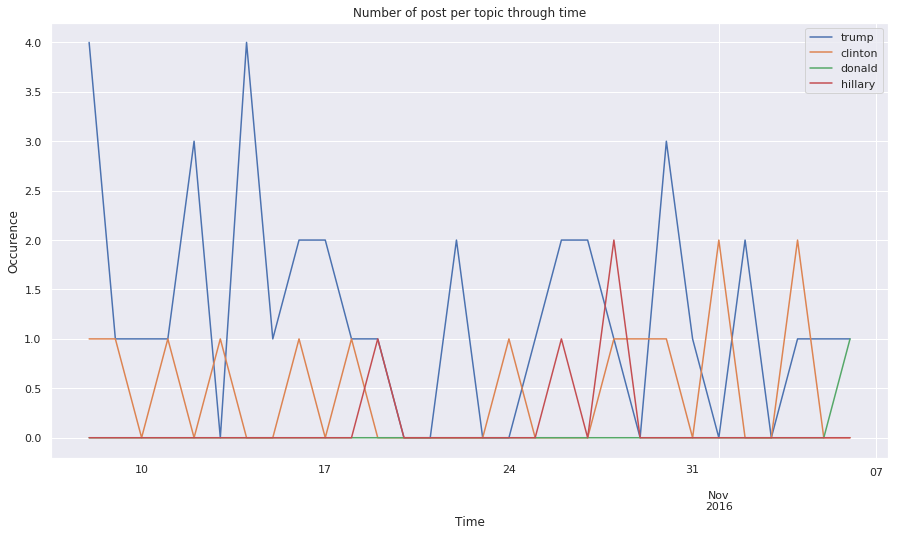

In [25]:
topics = ['trump', 'clinton', 'donald', 'hillary']
plot_frequency_of_topics(lda_result_one_w_df, topics)

The plot above shows us an interesting phenomena, although the word "clinton" and "hillary" were absent from the 20 most discussed topic we showed previously, both words seems to share a similar distribution in magnitude through time, whereas for Donald Trump, most of the time he's subjectified by its family name rather by its first name (which get recognized as a topic only once, on the 6th of November). Even though "clinton" might be referring to another person bearing this family name, the context of the election assures us this word probably refers to the same person as the word "hillary".

This might explain why Hillary Clinton was not as subjectified as Donald Trump according to the LDA results, the people would refer to her under two different words during discussion, while they would be more consistent with the current U.S. president by calling him "Trump".

Merging all the possible word as name for the presidential candidate gives us this distribution through time instead:

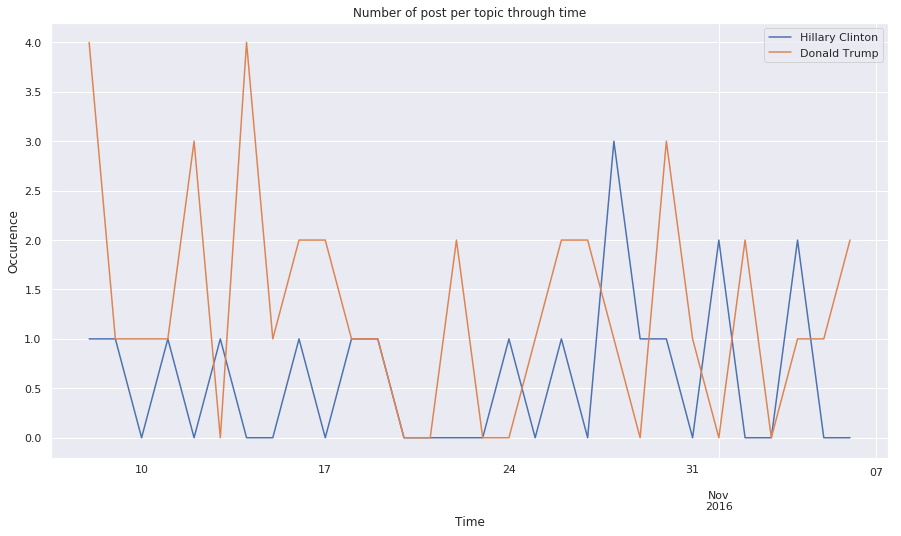

In [26]:
hc = 'Hillary Clinton'
dt = 'Donald Trump'
lda_result_one_w_df['topic'] = lda_result_one_w_df['topic'].map({'hillary': hc, 'clinton': hc, 'donald':dt, 'trump':dt})
plot_frequency_of_topics(lda_result_one_w_df, [hc, dt])

The corrected occurence through time distribution shows us that although Trump was the dominant subject at the beginning of the month of October, both subjects started to have an equal representation as the election day was coming.

This proves some trend analysis can be done using LDA, but we should take it with a grain of salt, as the number of occurence stays relatively low (under 5 posts whose topic was identified to be about a presidential candidate per day), probably because LDA will favor more general terms such as "people" or "would" as topic of discussion.

#### Trend Analysis using 2 topics by post, and 3 words per topic

The LDA algorithm allows some more fine grained topic modelling by changing the number of topic produced by thread, and the number of words that can constitute a topic. Testing LDA on the same sample but with increased topic and words per topic might maybe produce less general topics and maybe more representativeness of the actual topic of discussion. 

In [27]:
lda_result_three_w_df['topic'].value_counts().head(30)

people would think          10
people black white           8
right                        6
police people would          4
people think would           4
people would money           4
people black police          4
alive                        4
pretty                       4
video                        4
pipeline would people        3
would people think           3
insurance people would       3
police would officer         3
people driving think         3
people right would           3
people would government      3
would people police          3
people white black           3
insurance people health      3
mildlyvagina                 2
white people racist          2
account interest could       2
steve future world           2
hungover                     2
tribe pipeline company       2
cancer people money          2
trump supporter violence     2
epstein trump clinton        2
interest                     2
Name: topic, dtype: int64

Obviously, computing three words per topic greatly decreases the odds of having a high count for a given topic, as the most frequent topic being "people would think" occurs only 10 times through all the posts (whereas the topic "people" occured 394 times when considering only one word per topic). Having three words per topic gives a bit more information about the thread's subject, but give less chance of finding a coherent trend.

Regarding the U.S. election, no identical topics seems to adress the subject, but this might be because most topics modelled by the LDA about either Trump or Clinton are not coherent enough to be counted together. We can assume that a three words topic containing the name of either presidential candidate might speak about it, and thus count this way how much Clinton and Trump were discussed.

In [28]:
def replace_str(s):
    if s == 'hillary' or s == 'clinton':
        return hc
    elif s == 'donald' or s == 'trump':
        return dt
    else:
        return s

count_dict = {hc:0, dt:0}
for t in lda_result_three_w_df['topic']:
    ts = t.split(' ')
    ts = [replace_str(tok) for tok in ts]
    for k in count_dict.keys():
        if k in ts:
            count_dict[k] += 1
count_dict

{'Hillary Clinton': 92, 'Donald Trump': 173}

We get a much higher count of occurence in topics for the two presidential candidate than in previous exemple. This means that finding the good number of topics per post and words per topic, might help in correctly modelling the topic of a post, and thus detect trends.

### Extracting Tone and Vulgarity using NLP [WIP]

In addition to Topic Modelling, we tried to use natural language processing as a means to analyze the tone (positive, neutral, negative) and lack of repspect (vulgarity, hate speech) of each of the comments. Unfortunately, due to the size of the dataset, we were so far only able to run it on a few days (the first 5 days of January 2017). 

In [29]:
nlp_per_day = nlp_metrics_full.withColumn('dummy', func.lit(1)).groupBy('creation_date').sum()
pd_per_day = nlp_per_day.toPandas().set_index('creation_date').sort_index()
pd_percentage = pd_per_day.iloc[:, :-1].div(pd_per_day.iloc[:, -1], axis=0)
pd_percentage

sum(nltk_negativity)  sum(nltk_neutrality)  \
creation_date                                               
2017-01-01                 0.080891              0.769968   
2017-01-02                 0.078461              0.777082   
2017-01-03                 0.077053              0.780049   
2017-01-04                 0.076854              0.781258   
2017-01-05                 0.079842              0.779283   

               sum(nltk_positivity)  sum(text_blob_polarity)  \
creation_date                                                  
2017-01-01                 0.147190                 0.008921   
2017-01-02                 0.142812                 0.009211   
2017-01-03                 0.141465                 0.009071   
2017-01-04                 0.140451                 0.009240   
2017-01-05                 0.139467                 0.009249   

               sum(text_blob_subjectivity)  sum(nb_bw_matches)  \
creation_date                                                    
2017-01-01                        0.036027            0.094443   
2017-01-02                        0.036637            0.094494   
2017-01-03                        0.036886            0.092205   
2017-01-04                        0.037242            0.092980   
2017-01-05                        0.036869            0.097295   

               sum(nb_hw_matches)  sum(hw_ref_intensity)  \
creation_date                                              
2017-01-01               0.015949               0.001288   
2017-01-02               0.017424               0.001502   
2017-01-03               0.017310               0.001556   
2017-01-04               0.017489               0.001422   
2017-01-05               0.018126               0.002556   

               sum(nb_hw_ref_matches)  
creation_date                          
2017-01-01                   0.002093  
2017-01-02                   0.002413  
2017-01-03                   0.002474  
2017-01-04                   0.002292  
2017-01-05                   0.004225

In [30]:
# Average of each attribute over the 5 first day of January 2017
pd_percentage_avg = pd_percentage.mean(axis=0)
pd_percentage_avg

sum(nltk_negativity)           0.078620
sum(nltk_neutrality)           0.777528
sum(nltk_positivity)           0.142277
sum(text_blob_polarity)        0.009138
sum(text_blob_subjectivity)    0.036732
sum(nb_bw_matches)             0.094283
sum(nb_hw_matches)             0.017260
sum(hw_ref_intensity)          0.001665
sum(nb_hw_ref_matches)         0.002699
dtype: float64

Here is the meaning of each attribute:
1. nltk_negativity: Negativity percentage of a comment computed with the NLTK library.
2. nltk_neutrality: Neutrality percentage of a comment computed with the NLTK library
3. nltk_positivity: Positivity percentage of a comment computed with the NLTK library
4. text_blob_polarity: Polarity of a comment computer with the TextBlob library. Range: $x \in [-1, 1]$. -1 is negative polarity, 1 is positive polarity.
5. text_blob_subjectivity: Subjectivity of a comment computed with the TextBlob library. Range: $x \in [0, 1]$. 0 is very objective, 1 is very subjective.
6. nb_bw_matches: Percentage of messages containing bad words
7. nb_hw_matches: Percentage of messages containing hate words (The dataset used to compute this metric is very general)
9. hw_ref_intensity: Intensity of the hate words for the refined hate speech dataset (see below). Range: $x \in [0, 1]$. 0 is low intensity, 1 is very high intensity.
8. nb_hw_ref_matches: Percentage of messages containing refined hate words (The dataset used to compute this metric is less general, cleaner compared to the one use in nb_hw_matches)

##### Tone

We can already see in the result below that positive words seems to appear twice as much as negative words and that the vast majority of words that are used are neutral. Also, based on the subjectivity metrics, it seems that messages tend to be very objective, which is something we do not really expect for a social media. However, we must not forget that we are looking at a very small subsample of the dataset and therefore those metrics are not necessarily very relevant at the moment.

Notice that values don't seem to vary much from one day to another.

In [31]:
tone_metrics = pd_percentage.loc[:, :'sum(text_blob_subjectivity)']
tone_metrics

sum(nltk_negativity)  sum(nltk_neutrality)  \
creation_date                                               
2017-01-01                 0.080891              0.769968   
2017-01-02                 0.078461              0.777082   
2017-01-03                 0.077053              0.780049   
2017-01-04                 0.076854              0.781258   
2017-01-05                 0.079842              0.779283   

               sum(nltk_positivity)  sum(text_blob_polarity)  \
creation_date                                                  
2017-01-01                 0.147190                 0.008921   
2017-01-02                 0.142812                 0.009211   
2017-01-03                 0.141465                 0.009071   
2017-01-04                 0.140451                 0.009240   
2017-01-05                 0.139467                 0.009249   

               sum(text_blob_subjectivity)  
creation_date                               
2017-01-01                        0.036027  
2017-01-02                        0.036637  
2017-01-03                        0.036886  
2017-01-04                        0.037242  
2017-01-05                        0.036869

In [32]:
# Average of the metrics over the first 5 days of January 2017
avg_tone_metrics = pd_percentage_avg.loc[:'sum(text_blob_subjectivity)']
avg_tone_metrics

sum(nltk_negativity)           0.078620
sum(nltk_neutrality)           0.777528
sum(nltk_positivity)           0.142277
sum(text_blob_polarity)        0.009138
sum(text_blob_subjectivity)    0.036732
dtype: float64

##### Vulgarity

From the result below, we can see that in average, for the studied time period, 10% of messages contains bad words, and the quantity of messages containing hate speech varies from 0.2% based on the refined hate speech dataset to 1.7% based on the more general hatespeech dataset.

Notice that values don't seem to vary much from one day to another.

In [33]:
vulgarity_metrics = pd_percentage.loc[:, 'sum(nb_bw_matches)':]
vulgarity_metrics

sum(nb_bw_matches)  sum(nb_hw_matches)  sum(hw_ref_intensity)  \
creation_date                                                                  
2017-01-01               0.094443            0.015949               0.001288   
2017-01-02               0.094494            0.017424               0.001502   
2017-01-03               0.092205            0.017310               0.001556   
2017-01-04               0.092980            0.017489               0.001422   
2017-01-05               0.097295            0.018126               0.002556   

               sum(nb_hw_ref_matches)  
creation_date                          
2017-01-01                   0.002093  
2017-01-02                   0.002413  
2017-01-03                   0.002474  
2017-01-04                   0.002292  
2017-01-05                   0.004225

In [34]:
avg_vulgarity_metrics = pd_percentage_avg.loc['sum(nb_bw_matches)':]
avg_vulgarity_metrics

sum(nb_bw_matches)        0.094283
sum(nb_hw_matches)        0.017260
sum(hw_ref_intensity)     0.001665
sum(nb_hw_ref_matches)    0.002699
dtype: float64

##### Tone and vulgarity conclusion

It is clear that the time period studied is too small to conclude anything about the full dataset. However, it already gives us an idea about value magnitudes expected. Work is still in progress for this part and we expect to have more detailed results in the near future.

# MILESTONE 3

### NLP METRICS PLOTS

In [35]:
def spark_to_pandas(spark_metrics):
    metrics_pd = spark_metrics.toPandas()
    metrics_pd = metrics_pd.set_index('creation_date')
    metrics_pd = metrics_pd.sort_index()
    return metrics_pd

In [36]:
def get_metrics(filename, sql_query, sql_table_name):
    spark_metrics = spark.read.load(filename)
    spark_metrics.registerTempTable(sql_table_name)
    avg_metrics = spark.sql(sql_query)

    pd_metrics = spark_to_pandas(spark_metrics)
    pd_metrics_avg = spark_to_pandas(avg_metrics)
    pd_metrics_n = pd_metrics.div(pd_metrics['msg_count'], axis=0)
    pd_metrics_avg_n = pd_metrics_avg.div(pd_metrics_avg['msg_count_60d_avg'], axis=0)
    
    return pd_metrics_n, pd_metrics_avg_n, pd_metrics, pd_metrics_avg

### NLTK Metrics

In [37]:
nltk_full_name = '../data/nlp_nltk_metrics_daily_full_0.01.parquet/'
nltk_15_17_name = '../data/nlp_nltk_metrics_daily_15_17_0.1.parquet/'

nltk_sql_table_name = 'nltk_metrics'
nltk_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nltk_negativity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_negativity_60d_avg,

    AVG(sum_nltk_neutrality) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_neutrality_60d_avg,
    
    AVG(sum_nltk_positivity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_positivity_60d_avg

FROM {nltk_sql_table_name}
""")

def plot_nltk_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_averages(neg=True, neu=True, pos=True):
        plt.figure(figsize=(20, 10))
        title = None
        labels = []
        if neg:
            title = 'Negativity avg'
            labels.append('Negativity avg')
            plt.plot(m_avg_n['nltk_negativity_60d_avg'])
        if neu:
            title = 'Neutrality avg' if title is None else title + ' VS Neutrality avg'
            labels.append('Neutrality avg')
            plt.plot(m_avg_n['nltk_neutrality_60d_avg'])
        if pos:
            title = 'Positivity avg' if title is None else title + ' VS Positivity avg'
            labels.append('Positivity avg')
            plt.plot(m_avg_n['nltk_positivity_60d_avg'])
        plt.title(title + ' scores over time')
        plt.xlabel('Date')
        plt.ylabel('Score')
        plt.legend(labels)
    
    def plot_stat(neg=False, neu=False, pos=False):
        if neg or neu or pos:
            plt.figure(figsize=(20, 10))
        if neg:
            plt.plot(m_n['sum_nltk_negativity'])
            plt.plot(m_avg_n['nltk_negativity_60d_avg'])
            plt.title('Negativity scores over time')
            plt.legend(['Negativity', 'Negativity avg'])
        elif neu:
            plt.plot(m_n['sum_nltk_neutrality'])
            plt.plot(m_avg_n['nltk_neutrality_60d_avg'])
            plt.title('Neutrality scores over time')
            plt.legend(['Neutrality', 'Neutrality avg'])
        elif pos:
            plt.plot(m_n['sum_nltk_positivity'])
            plt.plot(m_avg_n['nltk_positivity_60d_avg'])
            plt.title('Positivity scores over time')
            plt.legend(['Positivity', 'Positivity avg'])
        else:
            print('Please set one of the following parameter to True: [neg, neu, pos]')
            return
        
        plt.xlabel('Date')
        plt.ylabel('Score')
            
    return plot_averages, plot_stat

#### NLTK 2005 - 2017

In [38]:
nltk_plot_averages, nltk_plot_stat = plot_nltk_metrics(nltk_full_name, nltk_sql_query, nltk_sql_table_name)

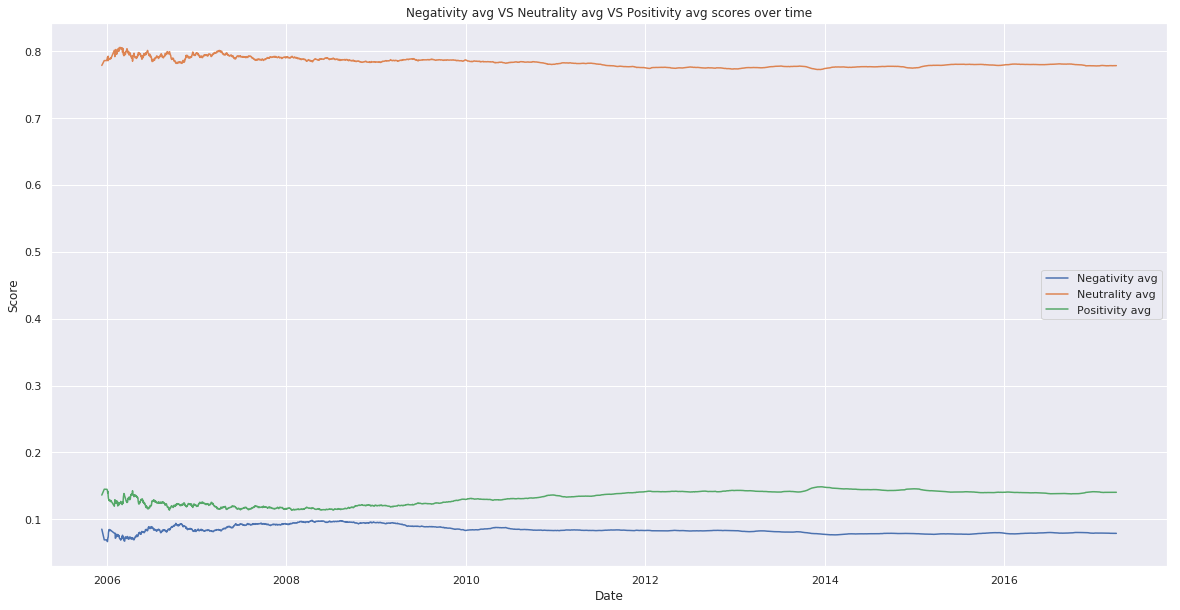

In [39]:
nltk_plot_averages()

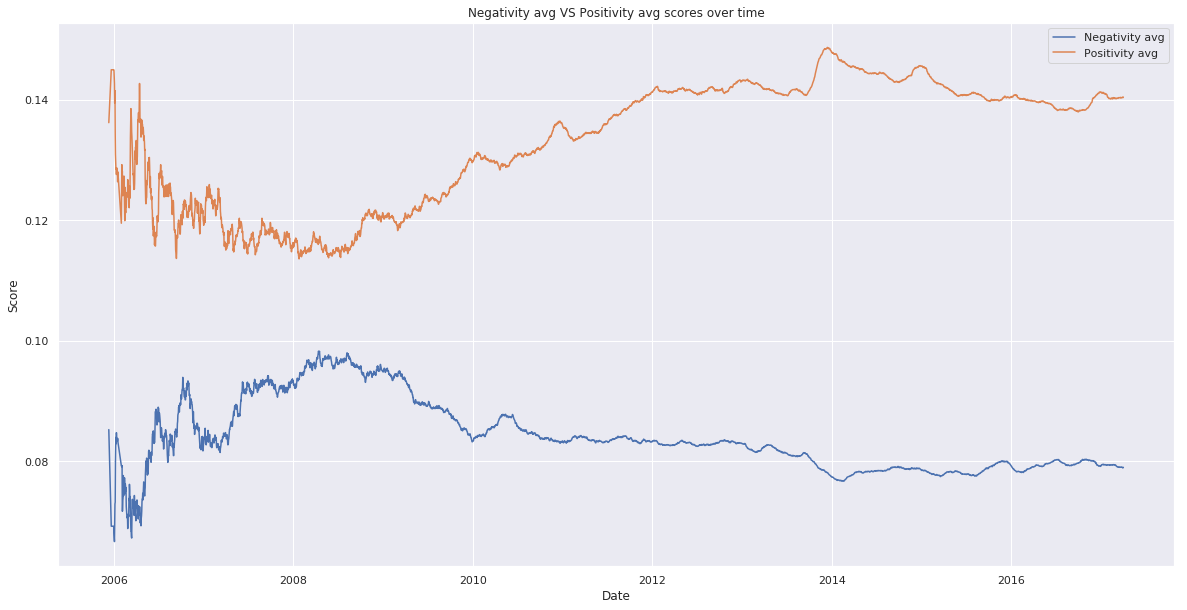

In [40]:
nltk_plot_averages(neu=False)

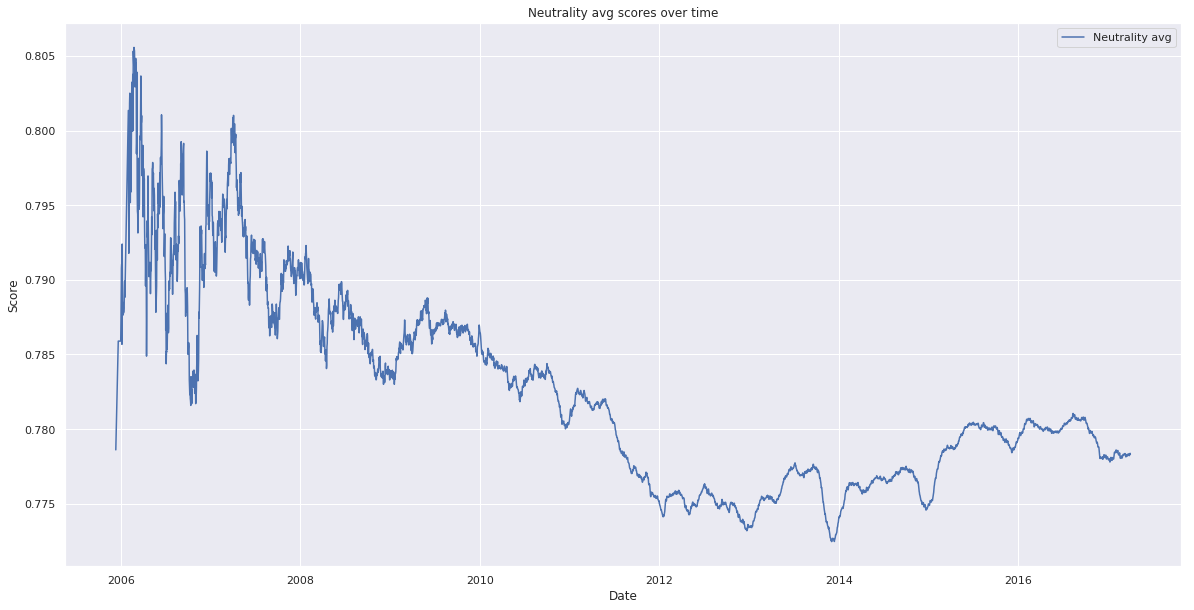

In [41]:
nltk_plot_averages(neg=False, pos=False)

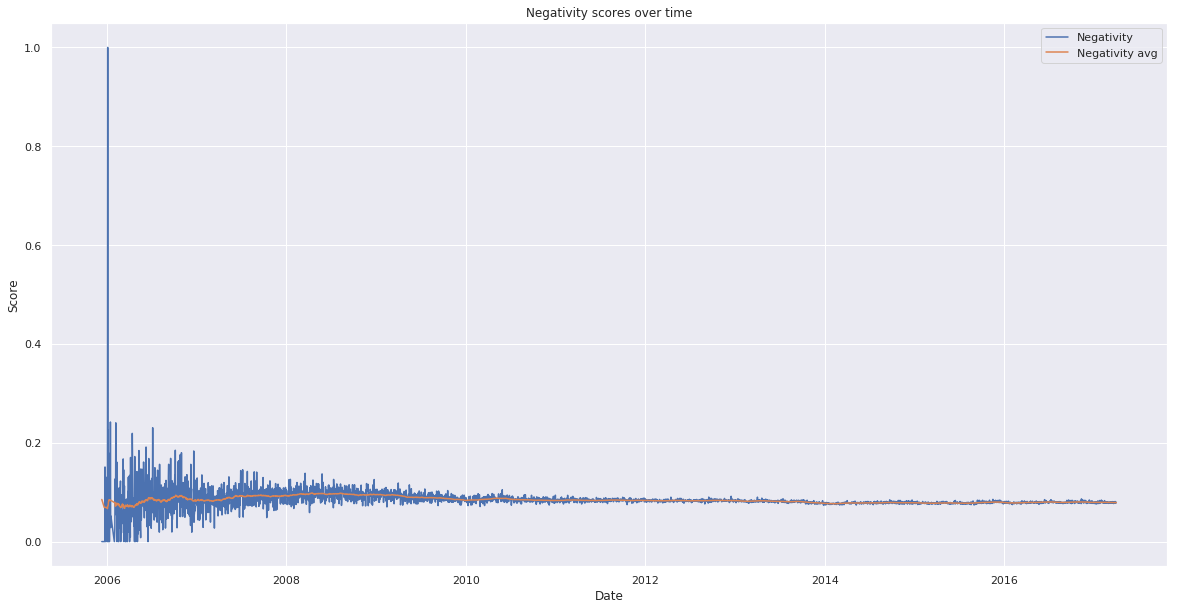

In [42]:
nltk_plot_stat(neg=True)

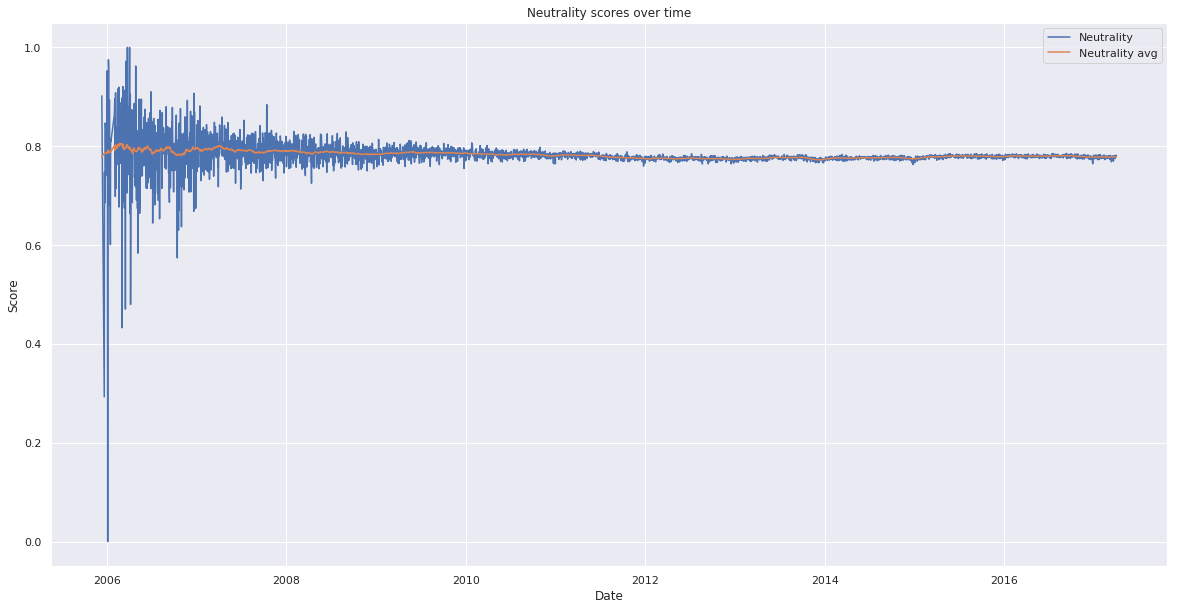

In [43]:
nltk_plot_stat(neu=True)

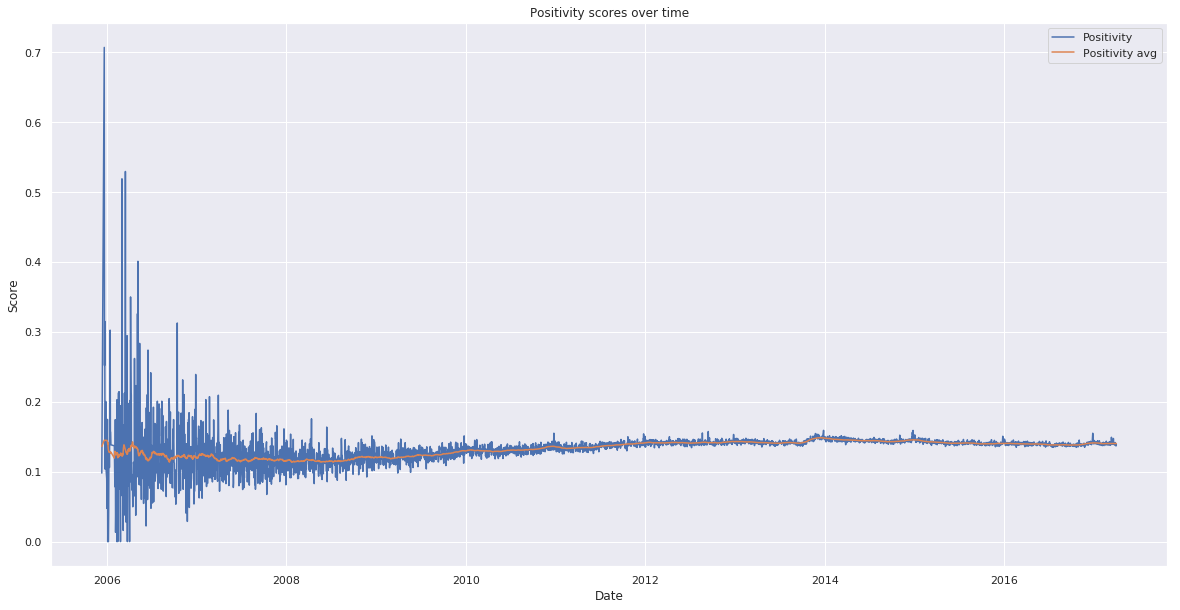

In [44]:
nltk_plot_stat(pos=True)

#### NLTK 2015 - 2017

In [45]:
nltk_plot_averages, nltk_plot_stat = plot_nltk_metrics(nltk_15_17_name, nltk_sql_query, nltk_sql_table_name)

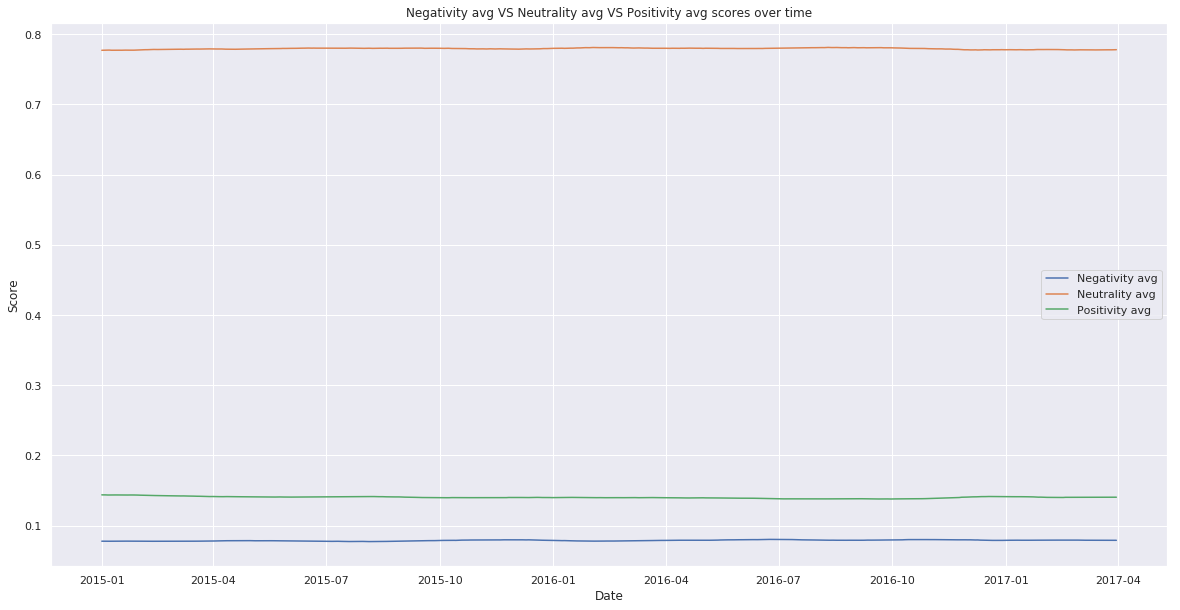

In [46]:
nltk_plot_averages()

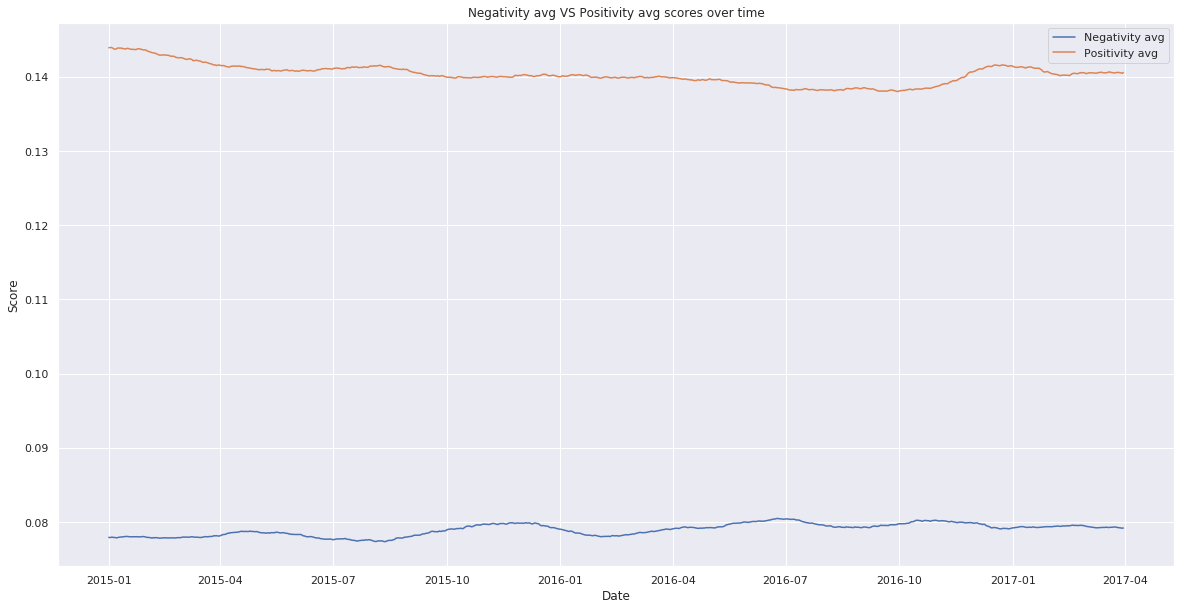

In [47]:
nltk_plot_averages(neu=False)

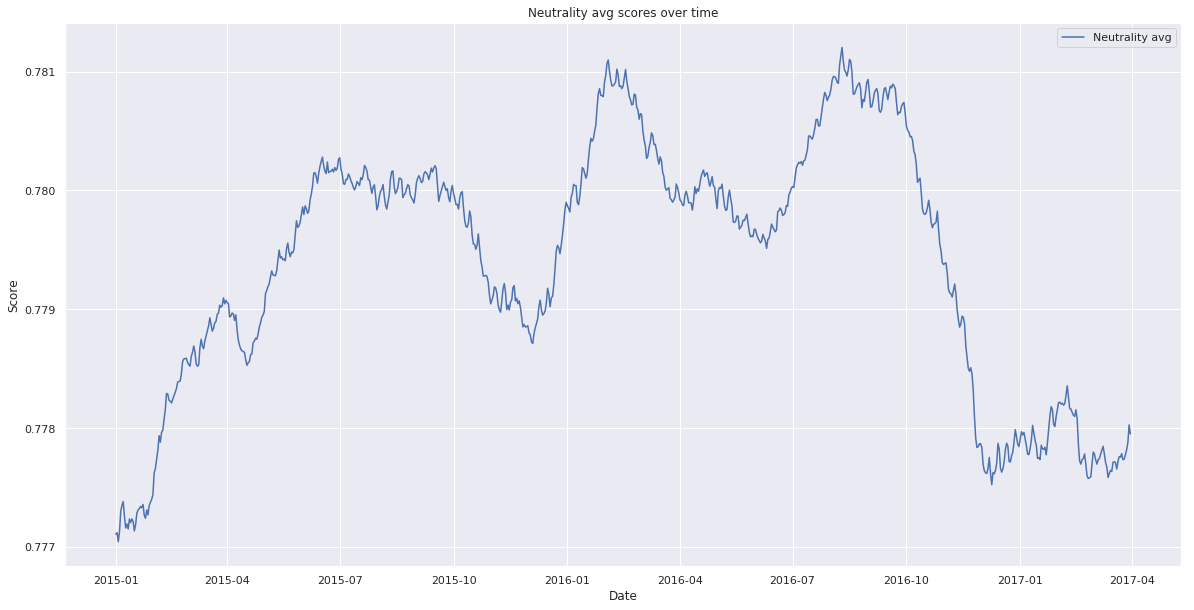

In [48]:
nltk_plot_averages(neg=False, pos=False)

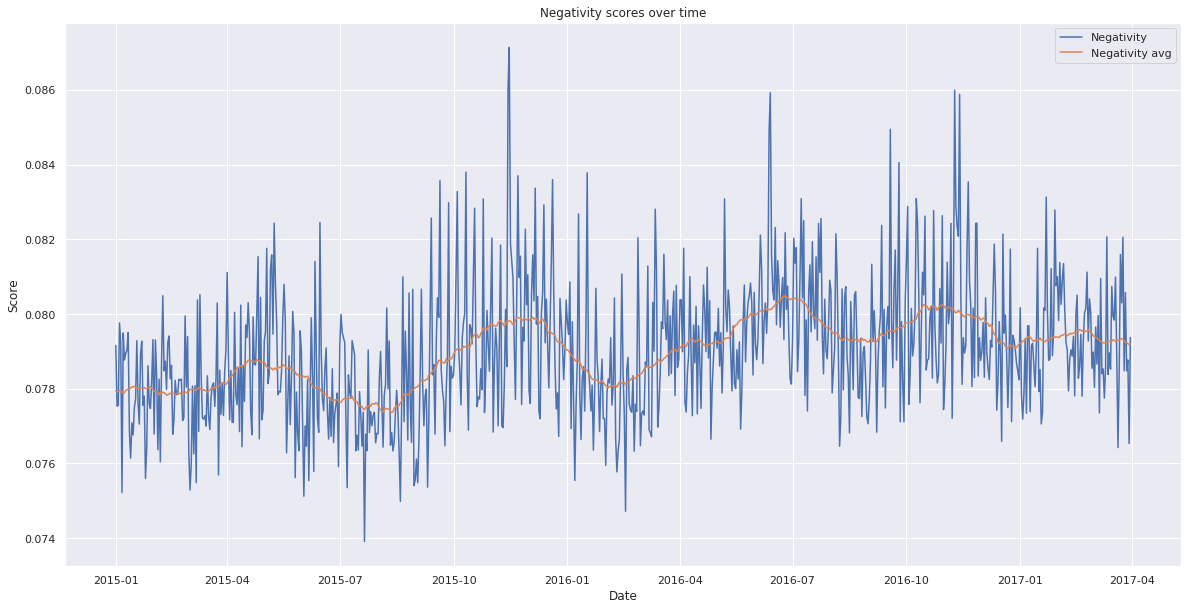

In [49]:
nltk_plot_stat(neg=True)

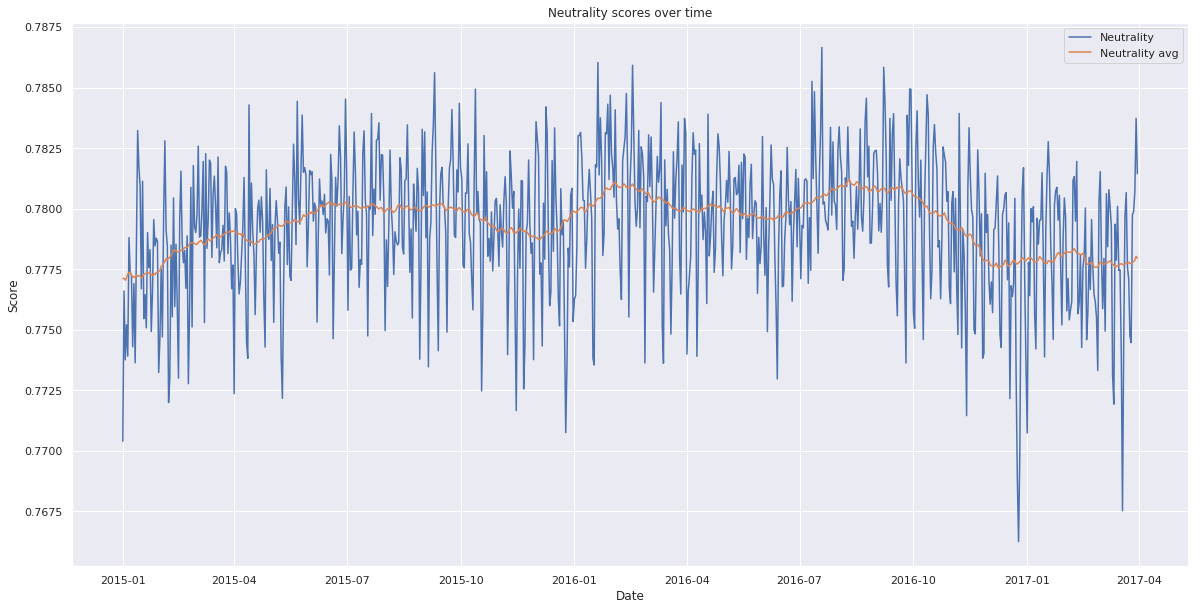

In [50]:
nltk_plot_stat(neu=True)

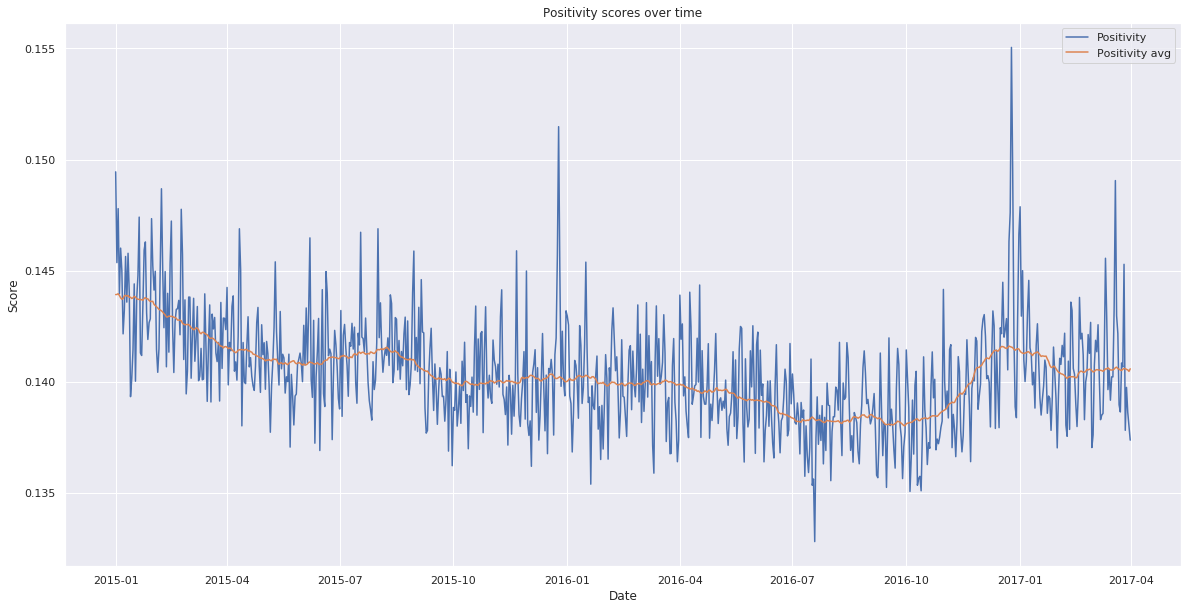

In [51]:
nltk_plot_stat(pos=True)

### TextBlob Metrics

In [52]:
blob_full_name = '../data/nlp_blob_metrics_daily_full_0.01.parquet/'
blob_15_17_name = '../data/nlp_blob_metrics_daily_15_17_0.1.parquet/'

blob_sql_table_name = 'blob_metrics'
blob_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_blob_polarity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS text_blob_polarity_60d_avg,

    AVG(sum_blob_subjectivity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS text_blob_subjectivity_60d_avg

FROM {blob_sql_table_name}
""")

def plot_blob_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_stat(pol=False, pol_avg=False, subj=False, subj_avg=False):
        if pol_avg or pol or subj_avg or subj:
            plt.figure(figsize=(20, 10))
            title = None
            labels = []
            if pol:
                plt.plot(m_n['sum_blob_polarity'])
                title = 'Polarity'
                labels.append('Polarity')
            if pol_avg:
                plt.plot(m_avg_n['text_blob_polarity_60d_avg'])
                title = 'Polarity avg' if title is None else title + ' VS Polarity avg'
                labels.append('Polarity avg')
            if subj:
                plt.plot(m_n['sum_blob_subjectivity'])
                title = 'Subjectivity' if title is None else title + ' VS Subjectivity'
                labels.append('Subjectivity')
            if subj_avg:
                plt.plot(m_avg_n['text_blob_subjectivity_60d_avg'])
                title = 'Subjectivity avg' if title is None else title + ' VS Subjectivity avg'
                labels.append('Subjectivity avg')
            plt.title(title + ' scores over time')
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.legend(labels)
        else:
            print('Please set one of the following parameter to True: [pol, pol_avg, subj, subj_avg]')
            
    return plot_stat

#### Blob 2005 - 2017

In [53]:
blob_plot_stat = plot_blob_metrics(blob_full_name, blob_sql_query, blob_sql_table_name)

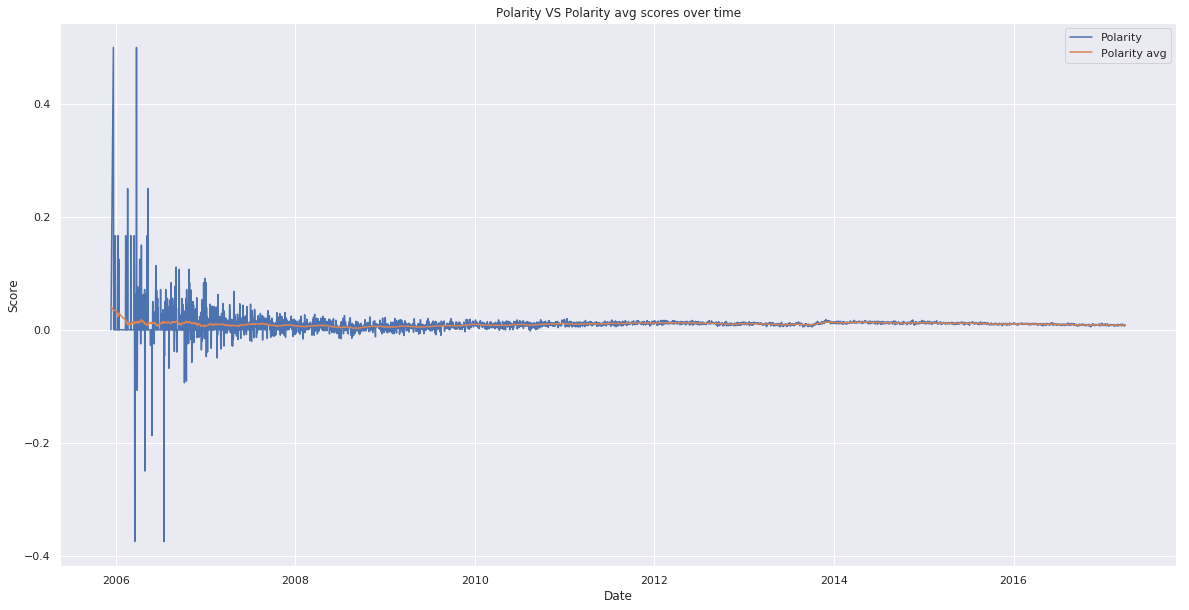

In [54]:
blob_plot_stat(pol=True, pol_avg=True)

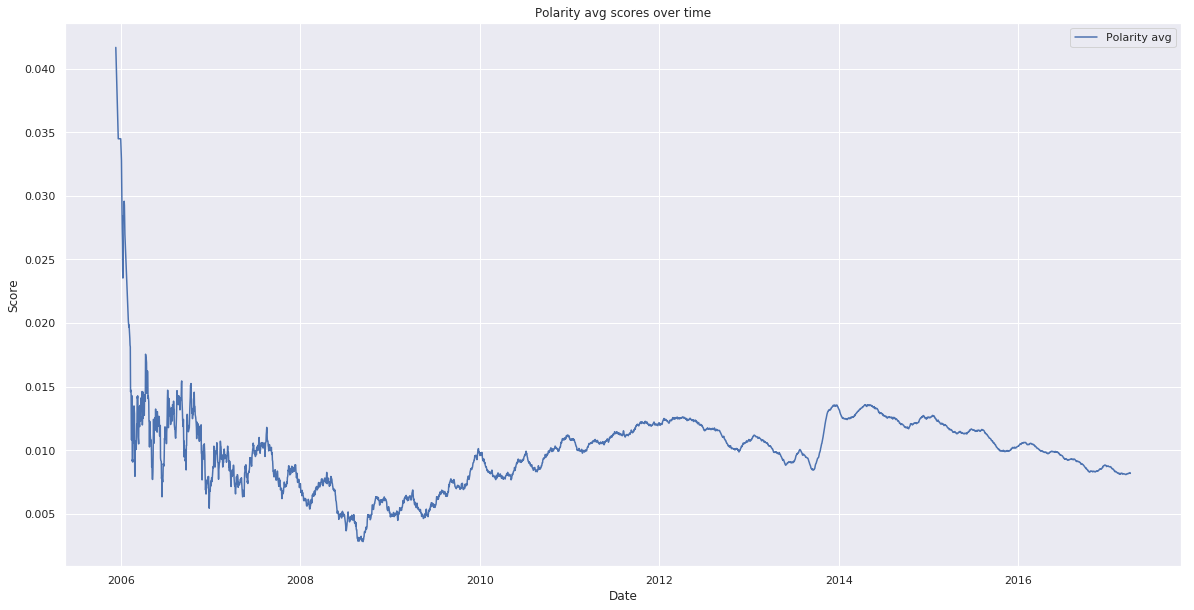

In [55]:
blob_plot_stat(pol_avg=True)

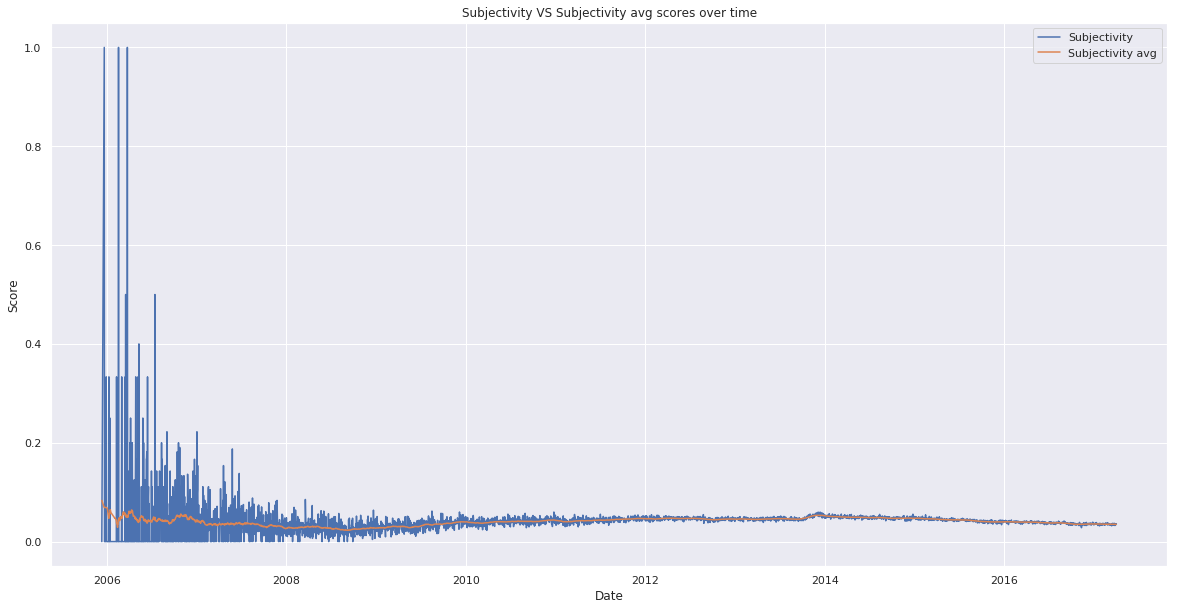

In [56]:
blob_plot_stat(subj=True, subj_avg=True)

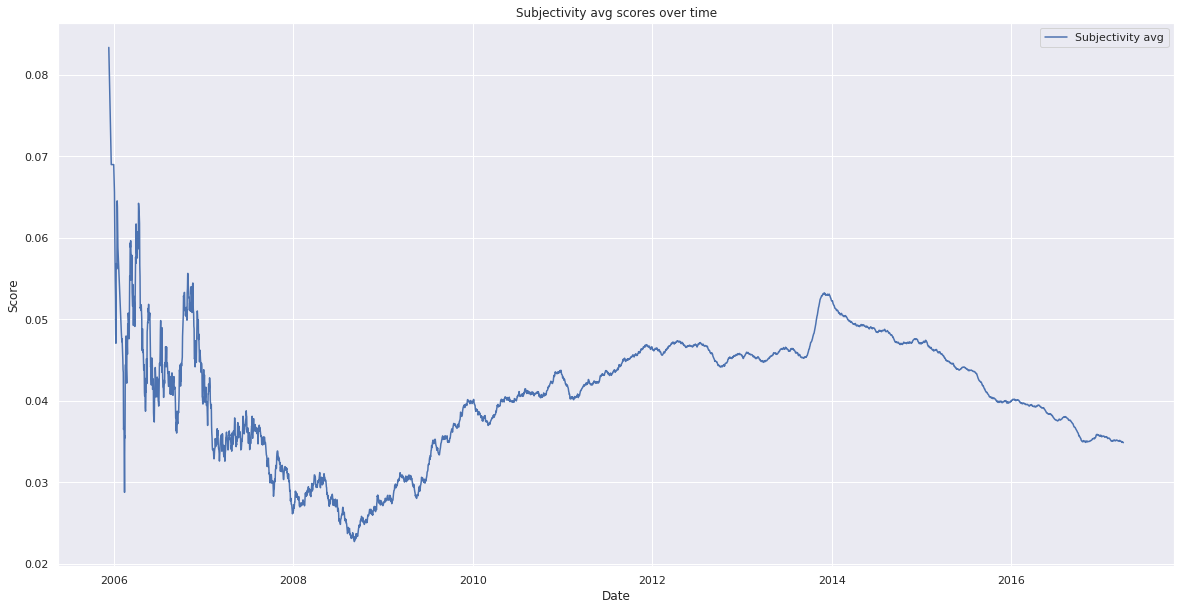

In [57]:
blob_plot_stat(subj_avg=True)

#### Blob 2015-2017

In [58]:
blob_plot_stat = plot_blob_metrics(blob_15_17_name, blob_sql_query, blob_sql_table_name)

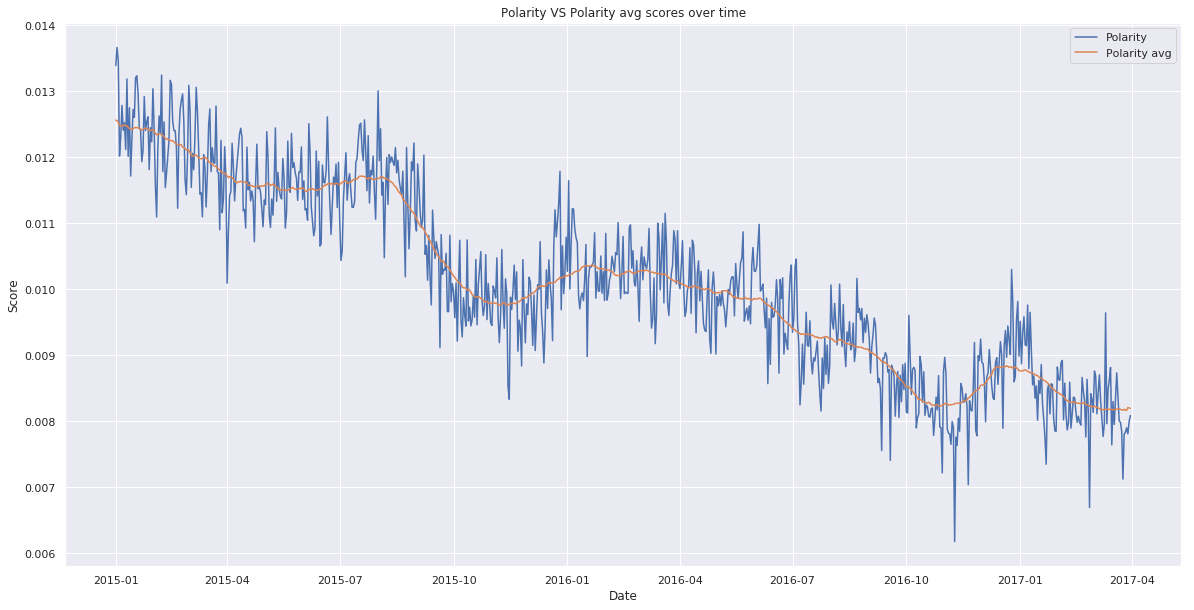

In [59]:
blob_plot_stat(pol=True, pol_avg=True)

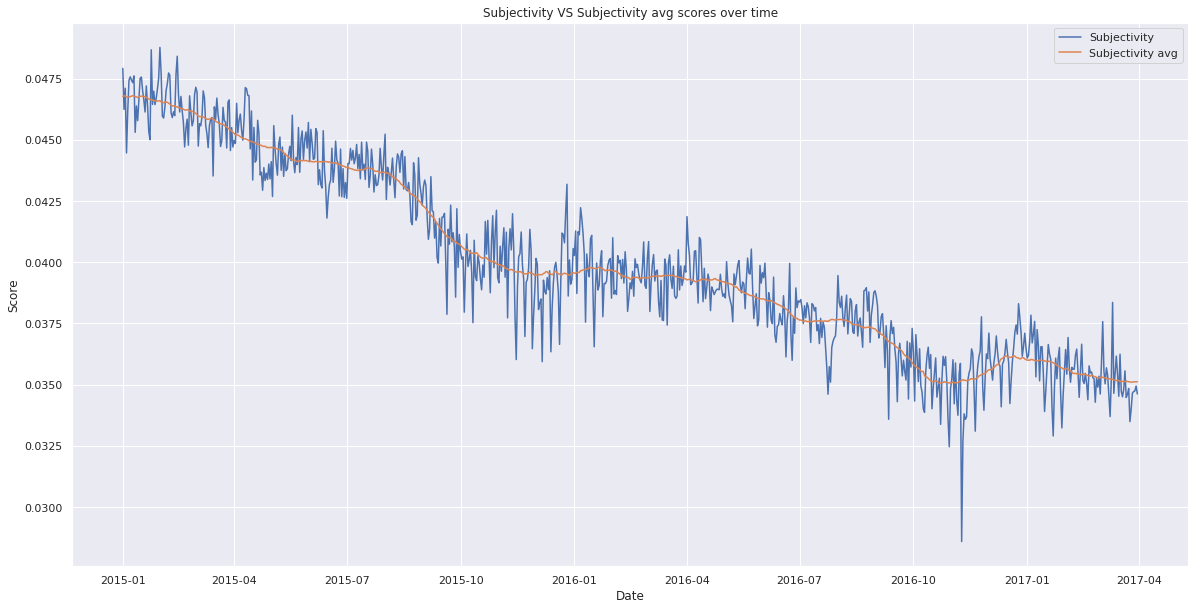

In [60]:
blob_plot_stat(subj=True, subj_avg=True)

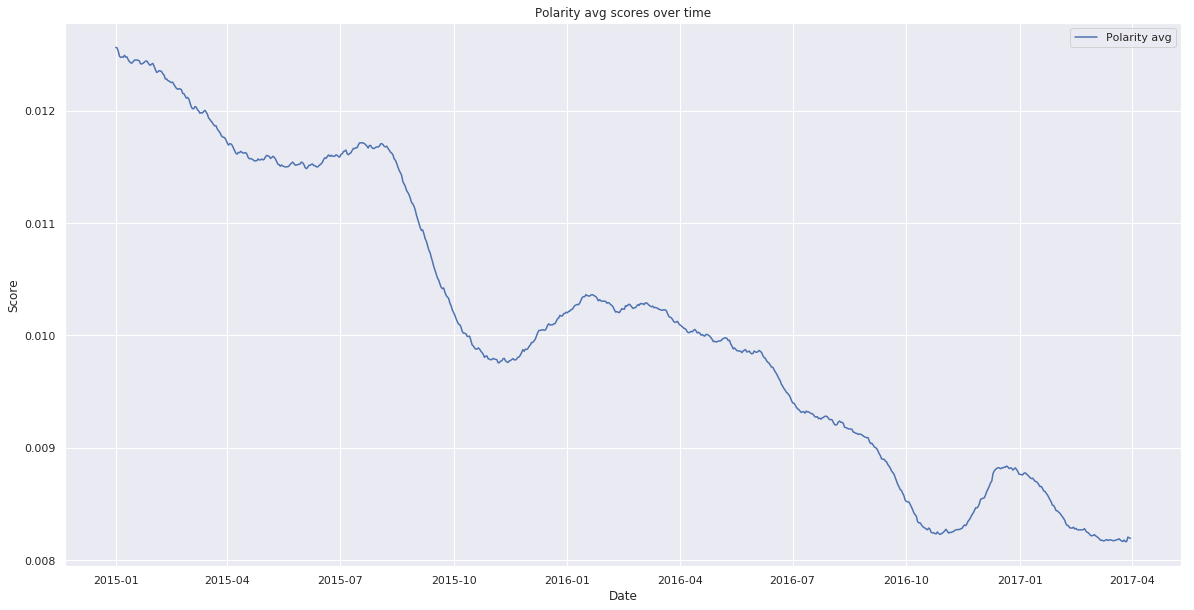

In [61]:
blob_plot_stat(pol_avg=True)

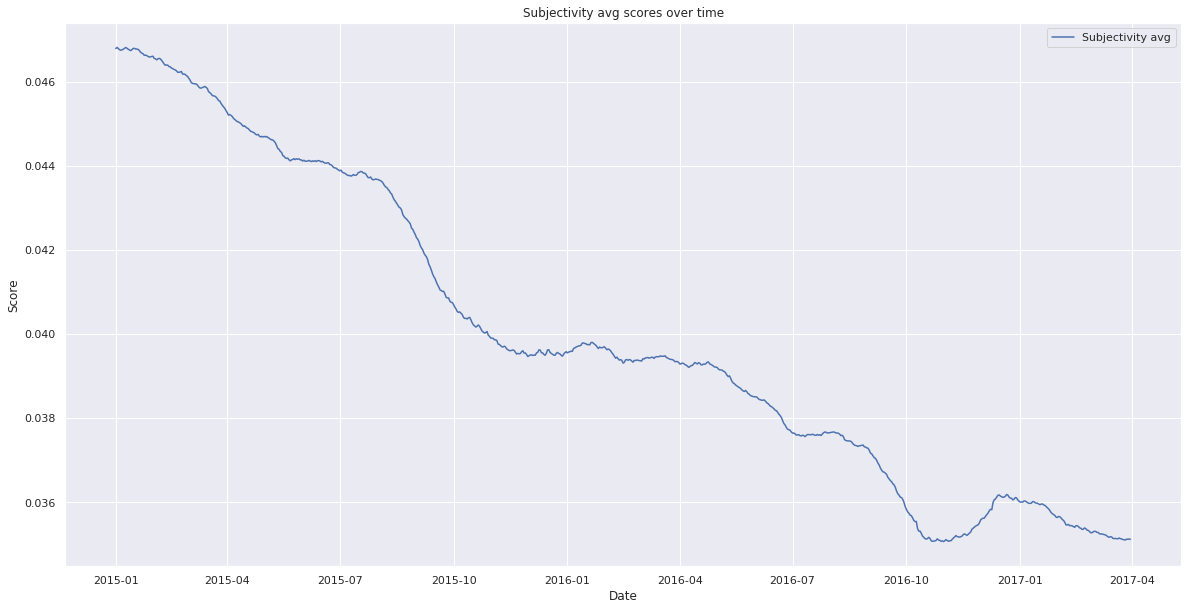

In [62]:
blob_plot_stat(subj_avg=True)

### Bad words metrics

In [63]:
bw_full_name = '../data/nlp_bw_metrics_daily_full_0.01.parquet/'
bw_15_17_name = '../data/nlp_bw_metrics_daily_15_17_0.1.parquet/'

bw_sql_table_name = 'bw_metrics'
bw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nb_bw_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_bw_matches_60d_avg

FROM {bw_sql_table_name}
""")

def plot_bw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_stat(bw=False, bw_avg=False):
        if bw or bw_avg:
            plt.figure(figsize=(20, 10))
            title = None
            labels = []
            if bw:
                plt.plot(m_n['sum_nb_bw_matches'])
                title = 'Bad words'
                labels.append('Bad words')
            if bw_avg:
                plt.plot(m_avg_n['nb_bw_matches_60d_avg'])
                title = 'Bad words avg' if title is None else title + ' VS Bad words avg'
                labels.append('Bad words avg')
                
            plt.title(title + ' scores over time')
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.legend(labels)
        else:
            print('Please set one of the following parameter to True: [bw, bw_avg]')
            
    return plot_stat

#### Bad words 2005-2017

In [64]:
bw_plot_stat = plot_bw_metrics(bw_full_name, bw_sql_query, bw_sql_table_name)

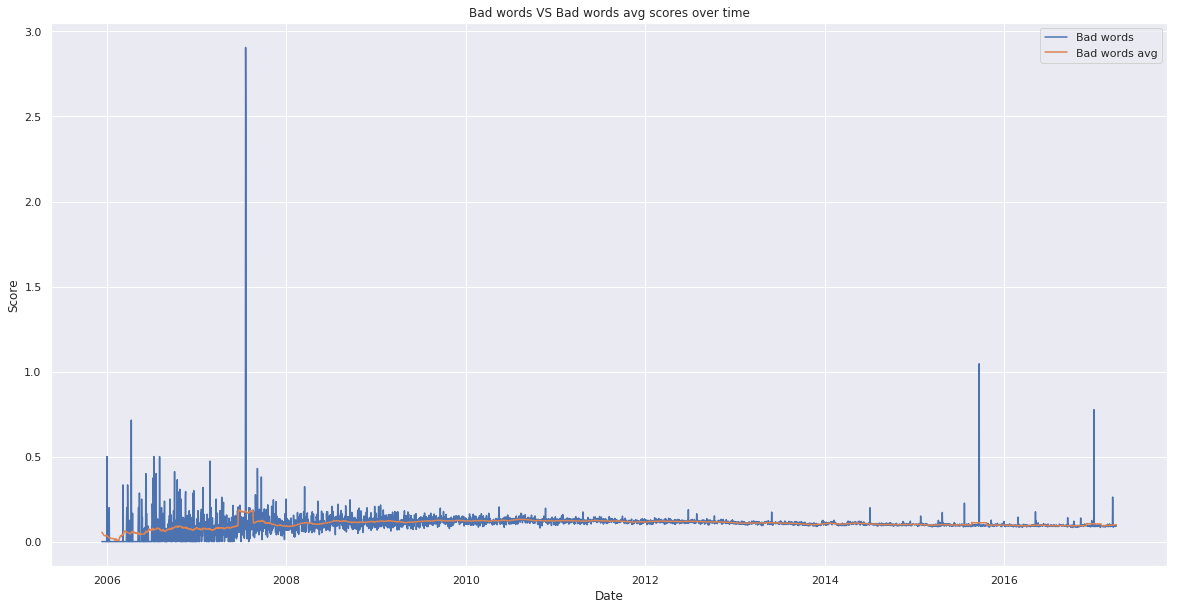

In [65]:
bw_plot_stat(bw=True, bw_avg=True)

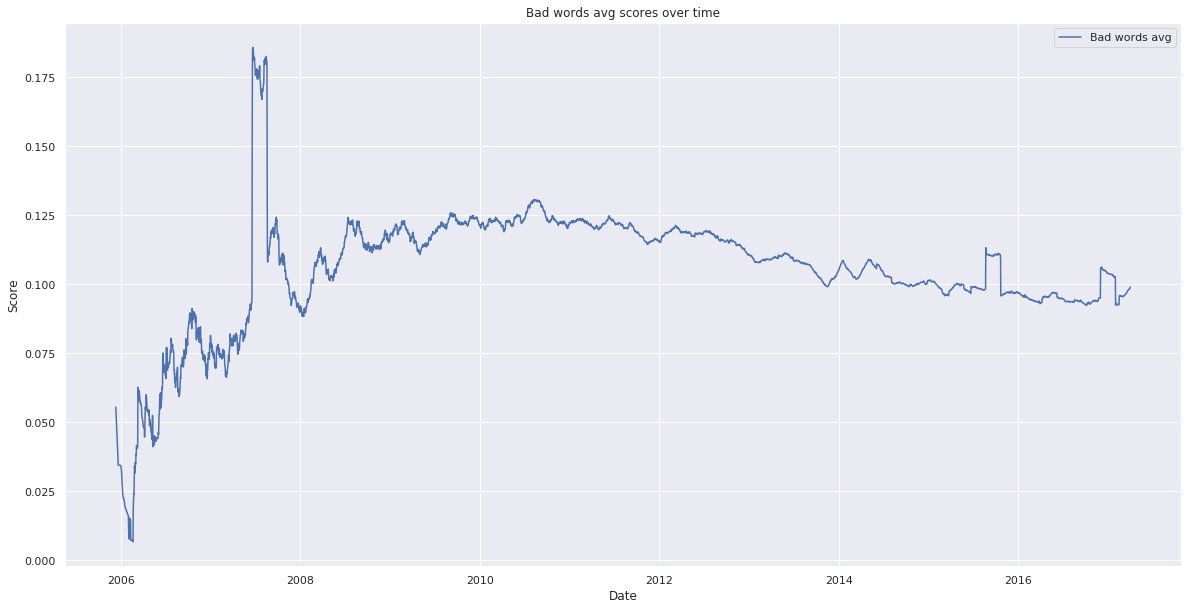

In [66]:
bw_plot_stat(bw_avg=True)

#### Bad words 2015-2017

In [67]:
bw_plot_stat = plot_bw_metrics(bw_15_17_name, bw_sql_query, bw_sql_table_name)

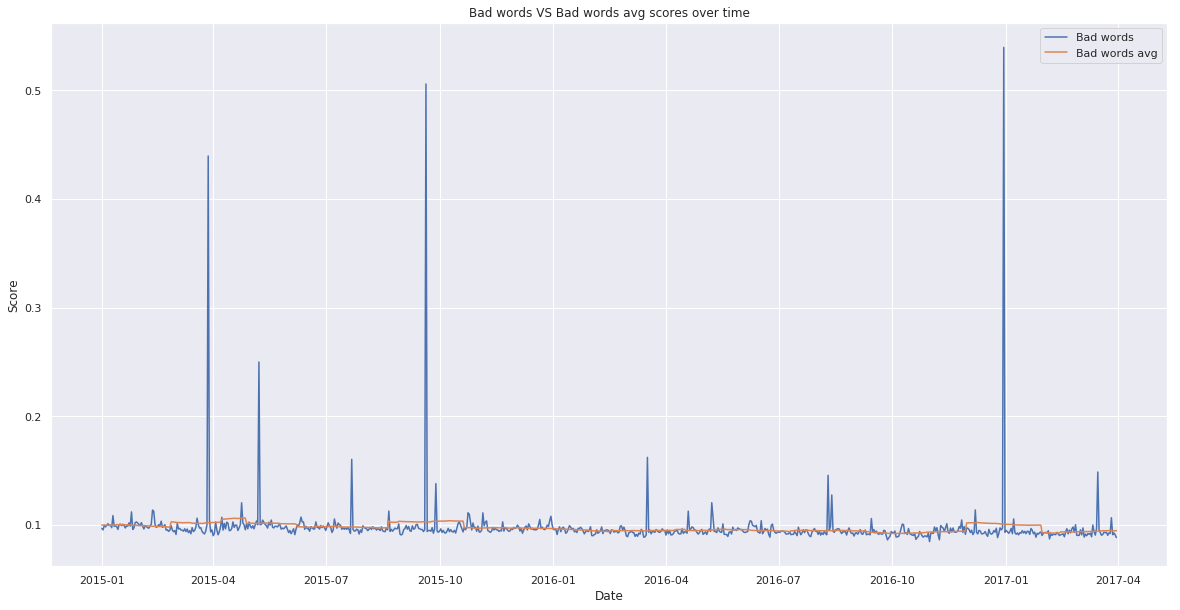

In [68]:
bw_plot_stat(bw=True, bw_avg=True)

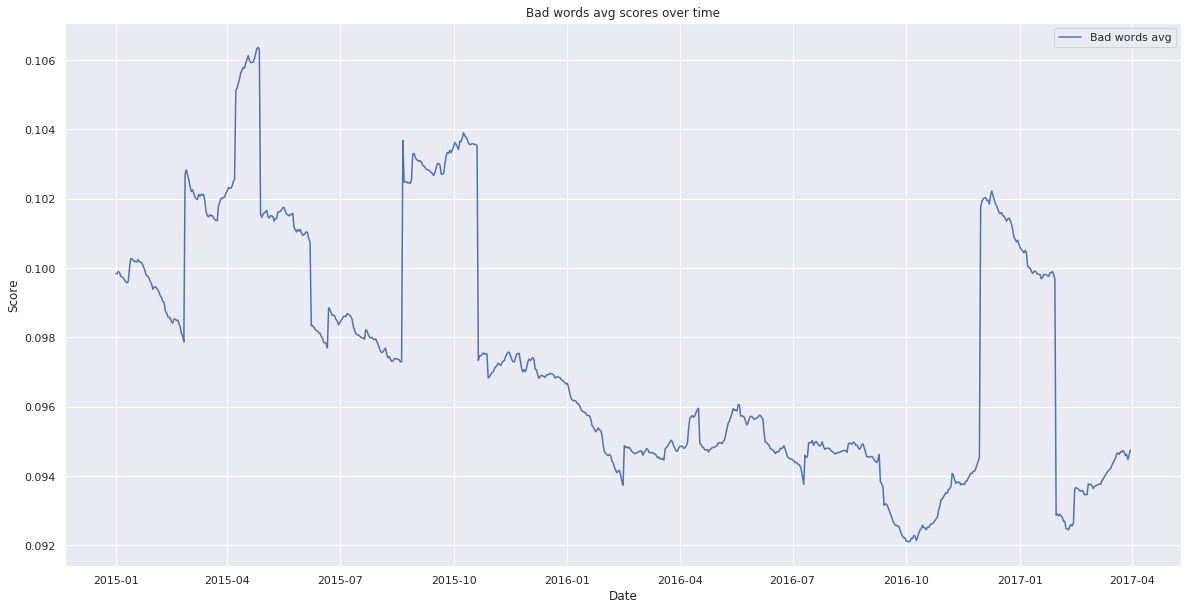

In [69]:
bw_plot_stat(bw_avg=True)

### Hate words metrics

In [70]:
hw_full_name = '../data/nlp_hw_metrics_daily_full_0.01.parquet/'
hw_15_17_name = '../data/nlp_hw_metrics_daily_15_17_0.1.parquet/'

hw_sql_table_name = 'hw_metrics'
hw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nb_hw_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_hw_matches_60d_avg

FROM {hw_sql_table_name}
""")

def plot_hw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_stat(hw=False, hw_avg=False):
        if hw or hw_avg:
            plt.figure(figsize=(20, 10))
            title = None
            labels = []
            if hw:
                plt.plot(m_n['sum_nb_hw_matches'])
                title = 'Hate words'
                labels.append('Hate words')
            if hw_avg:
                plt.plot(m_avg_n['nb_hw_matches_60d_avg'])
                title = 'Hate words avg' if title is None else title + ' VS Hate words avg'
                labels.append('Hate words avg')
            plt.title(title + ' scores over time')
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.legend(labels)
        else:
            print('Please set one of the following parameter to True: [hw, hw_avg]')
            
    return plot_stat

#### Hate words 2005-2017

In [71]:
hw_plot_stat = plot_hw_metrics(hw_full_name, hw_sql_query, hw_sql_table_name)

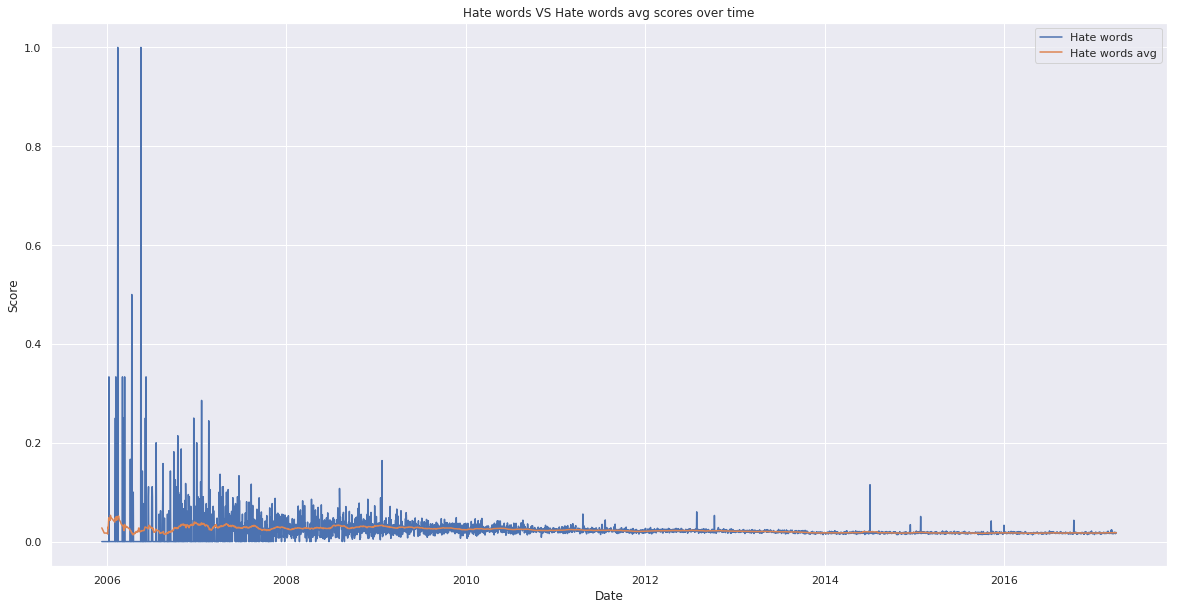

In [72]:
hw_plot_stat(hw=True, hw_avg=True)

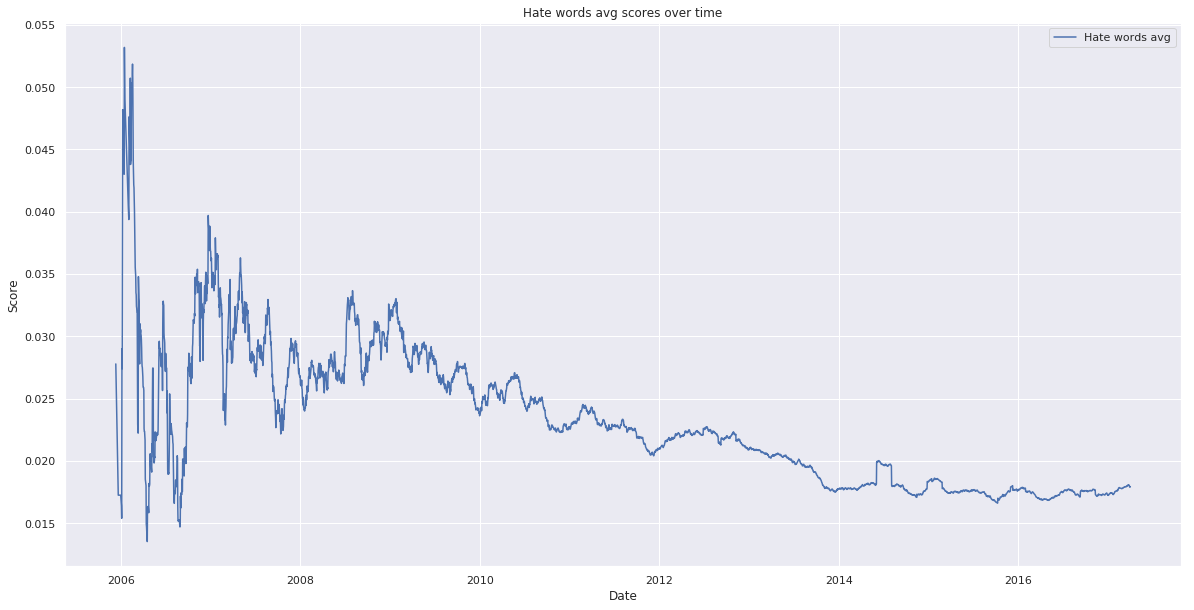

In [73]:
hw_plot_stat(hw_avg=True)

#### Hate words 2015-2017

In [74]:
hw_plot_stat = plot_hw_metrics(hw_15_17_name, hw_sql_query, hw_sql_table_name)

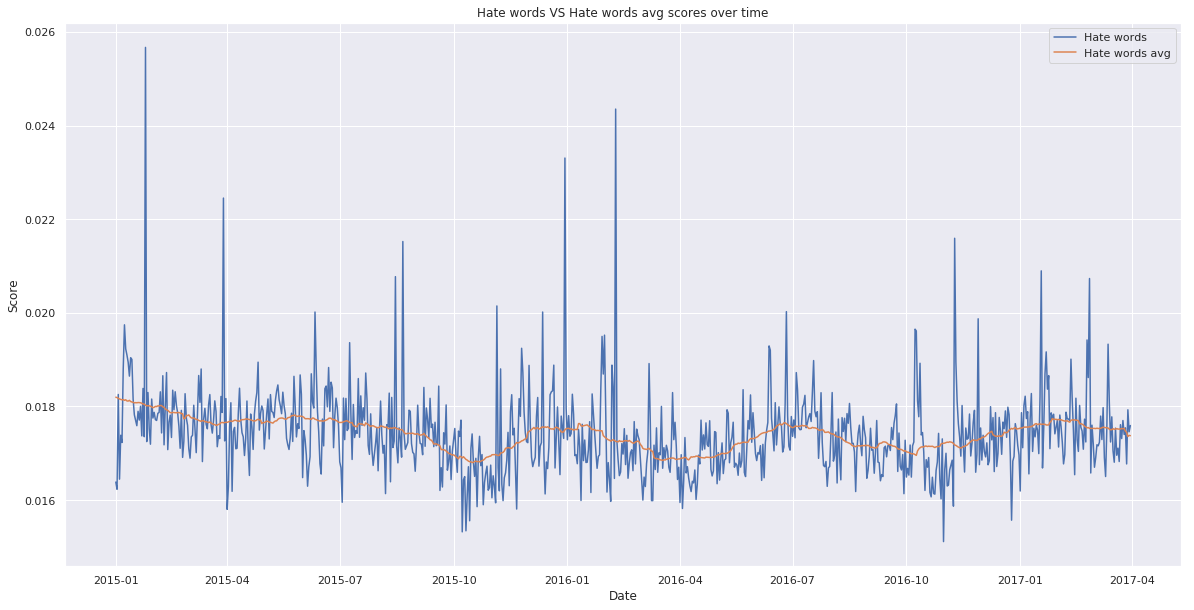

In [75]:
hw_plot_stat(hw=True, hw_avg=True)

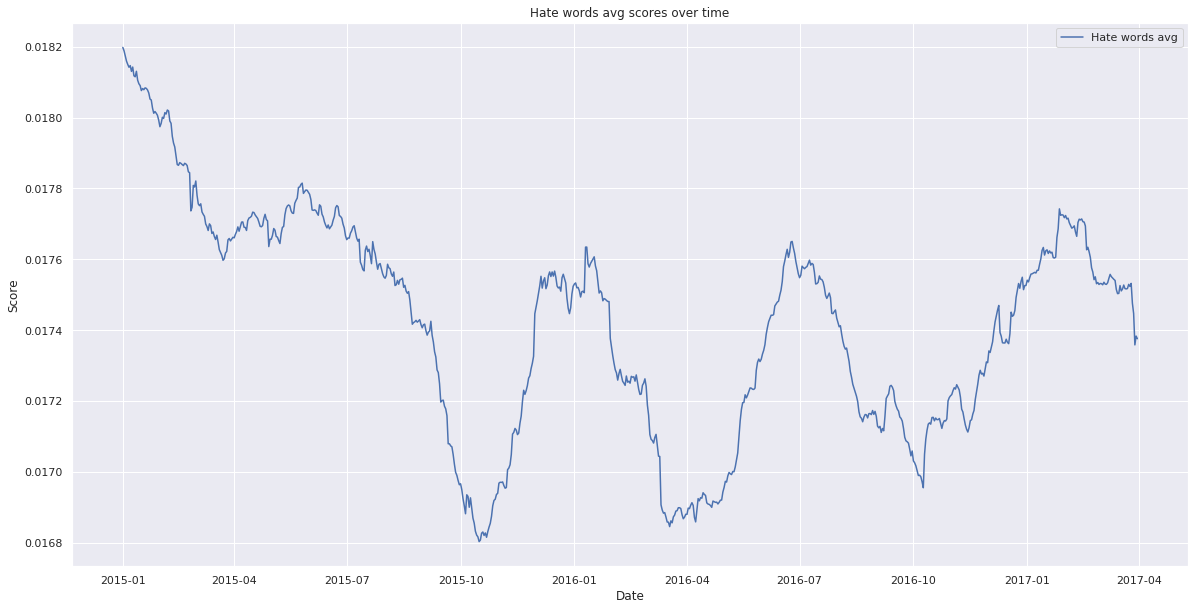

In [76]:
hw_plot_stat(hw_avg=True)

### Refined Hate Words

In [77]:
ref_hw_full_name = '../data/nlp_ref_hw_metrics_daily_full_0.01.parquet/'
ref_hw_15_17_name = '../data/nlp_ref_hw_metrics_daily_15_17_0.1.parquet/'

ref_hw_sql_table_name = 'ref_hw_metrics'
ref_hw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,
    
    AVG(sum_hw_ref_intensity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS hw_ref_intensity_60d_avg,

    AVG(sum_nb_hw_ref_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_hw_ref_matches_60d_avg

FROM {ref_hw_sql_table_name}
""")

def plot_ref_hw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    def plot_stat(ref_hw=False, ref_hw_avg=False, intensity=False, intensity_avg=False):
        if ref_hw or ref_hw_avg or intensity or intensity_avg:
            plt.figure(figsize=(20, 10))
            title = None
            labels = []
            if ref_hw:
                plt.plot(m_n['sum_nb_hw_ref_matches'])
                title = 'Hate words refined'
                labels.append('Hate words refined')
            if ref_hw_avg:
                plt.plot(m_avg_n['nb_hw_ref_matches_60d_avg'])
                title = 'Hate words refined avg' if title is None else title + ' VS Hate words refined avg'
                labels.append('Hate words refined avg')
            if intensity:
                plt.plot(m_n['sum_hw_ref_intensity'])
                title = 'Hate words refined intensity' if title is None else title + ' VS Hate words refined intensity'
                labels.append('Hate words refined intensity')
            if intensity_avg:
                plt.plot(m_avg_n['hw_ref_intensity_60d_avg'])
                title = 'Hate words refined intensity avg' if title is None else title + ' VS Hate words refined intensity avg'
                labels.append('Hate words refined intensity avg')
            
            plt.title(title + ' scores over time')
            plt.xlabel('Date')
            plt.ylabel('Score')
            plt.legend(labels)
        else:
            print('Please set one of the following parameter to True: [ref_hw, ref_hw_avg, intensity, intensity_avg]')
            
    return plot_stat

In [78]:
ref_hw_plot_stat = plot_ref_hw_metrics(ref_hw_full_name, ref_hw_sql_query, ref_hw_sql_table_name)

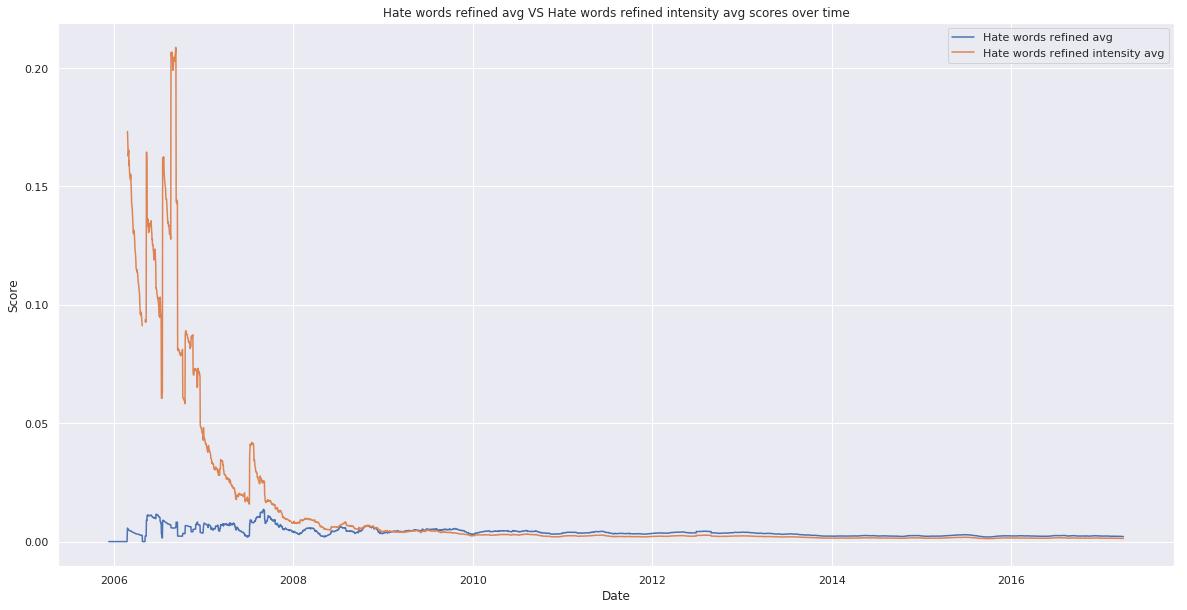

In [79]:
ref_hw_plot_stat(ref_hw_avg=True, intensity_avg=True)

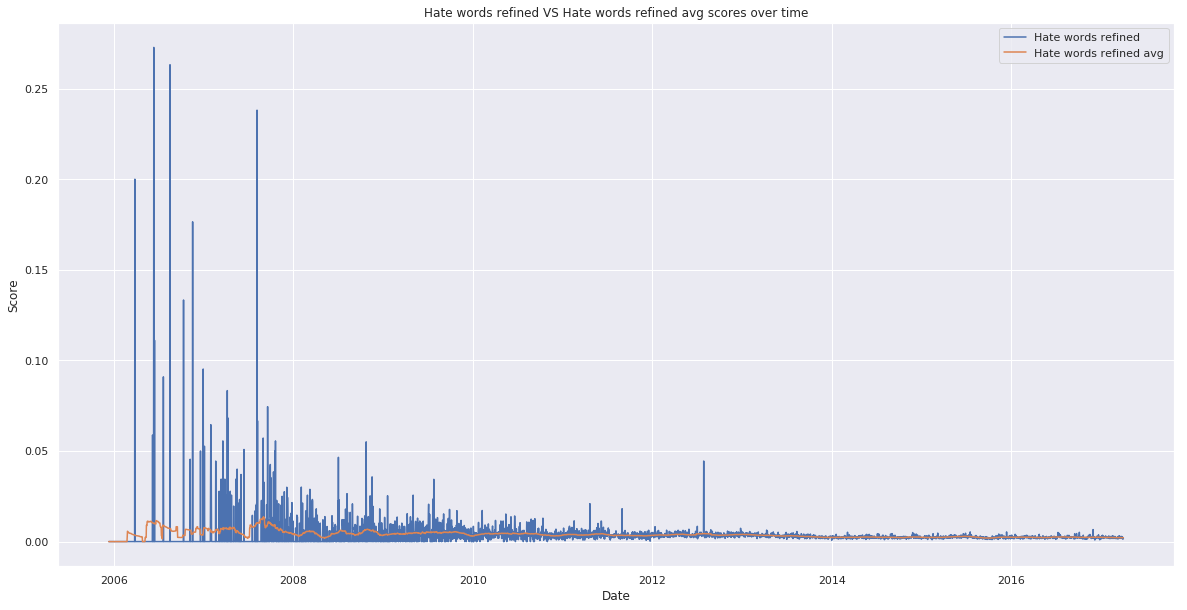

In [80]:
ref_hw_plot_stat(ref_hw=True, ref_hw_avg=True)

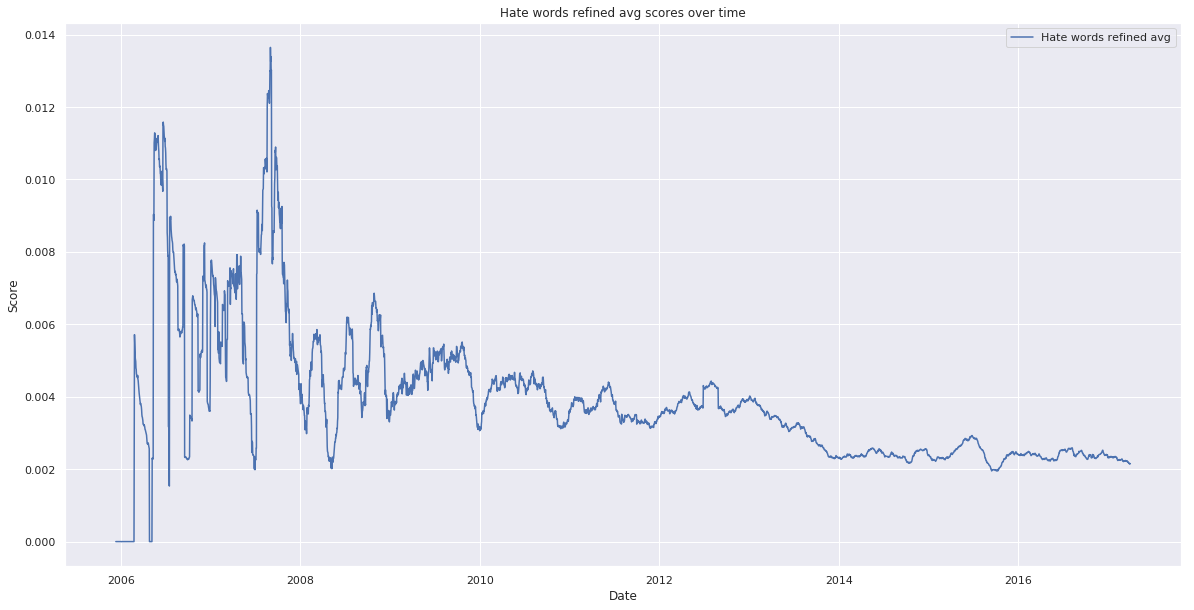

In [81]:
ref_hw_plot_stat(ref_hw_avg=True)

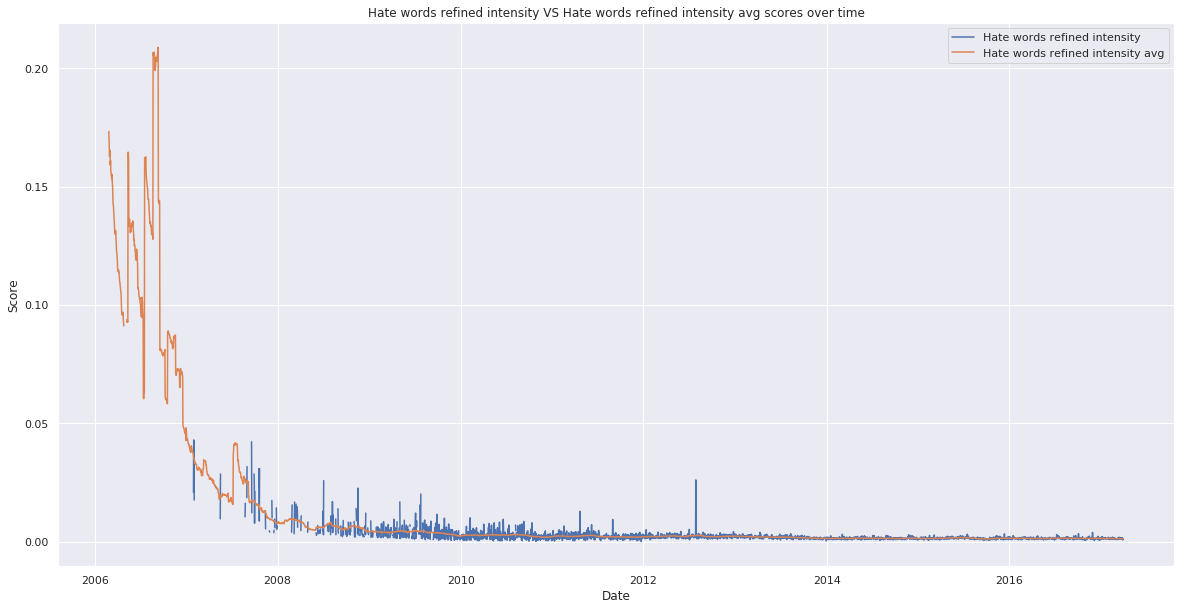

In [82]:
ref_hw_plot_stat(intensity=True, intensity_avg=True)

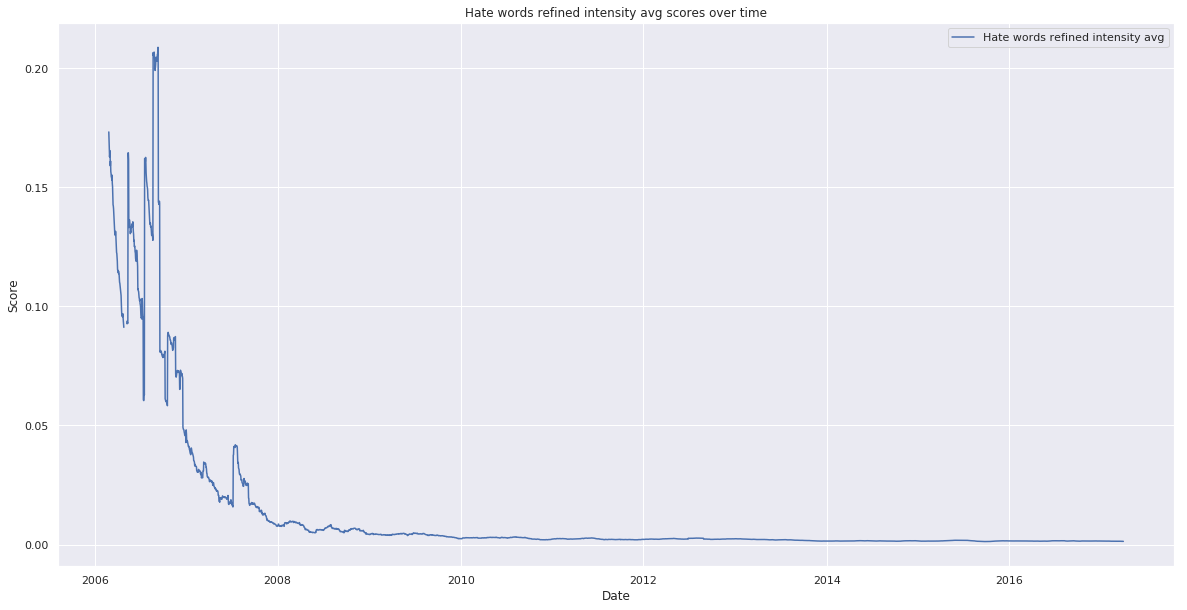

In [83]:
ref_hw_plot_stat(intensity_avg=True)

### Correlation analysis

In [84]:
nltk_n, nltk_avg_n, _, _ = get_metrics(nltk_full_name, nltk_sql_query, nltk_sql_table_name)
blob_n, blob_avg_n, _, _ = get_metrics(blob_full_name, blob_sql_query, blob_sql_table_name)
bw_n, bw_avg_n, _, _ = get_metrics(bw_full_name, bw_sql_query, bw_sql_table_name)
hw_n, hw_avg_n, _, _ = get_metrics(hw_full_name, hw_sql_query, hw_sql_table_name)
hw_ref_n, hw_ref_avg_n, _, _ = get_metrics(ref_hw_full_name, ref_hw_sql_query, ref_hw_sql_table_name)
nlp_n = pd.concat([nltk_n, blob_n, bw_n, hw_n, hw_ref_n], axis=1, sort=True).drop('msg_count', axis=1)

In [85]:
nlp_n.columns = ['neg', 'neu', 'pos', 'pol', 'subj', 'bw', 'hw', 'hw_ref', 'intensity']
pd.to_pickle(nlp_n, '../data/daily_nlp_metrics_merged.pkl')

In [86]:
nlp_n = pd.read_pickle('../data/daily_nlp_metrics_merged.pkl').dropna()
# Remove outliers assuming gaussian distribution
nlp_n_cleaned = nlp_n[(sp.stats.zscore(nlp_n) < 3).all(axis=1)]

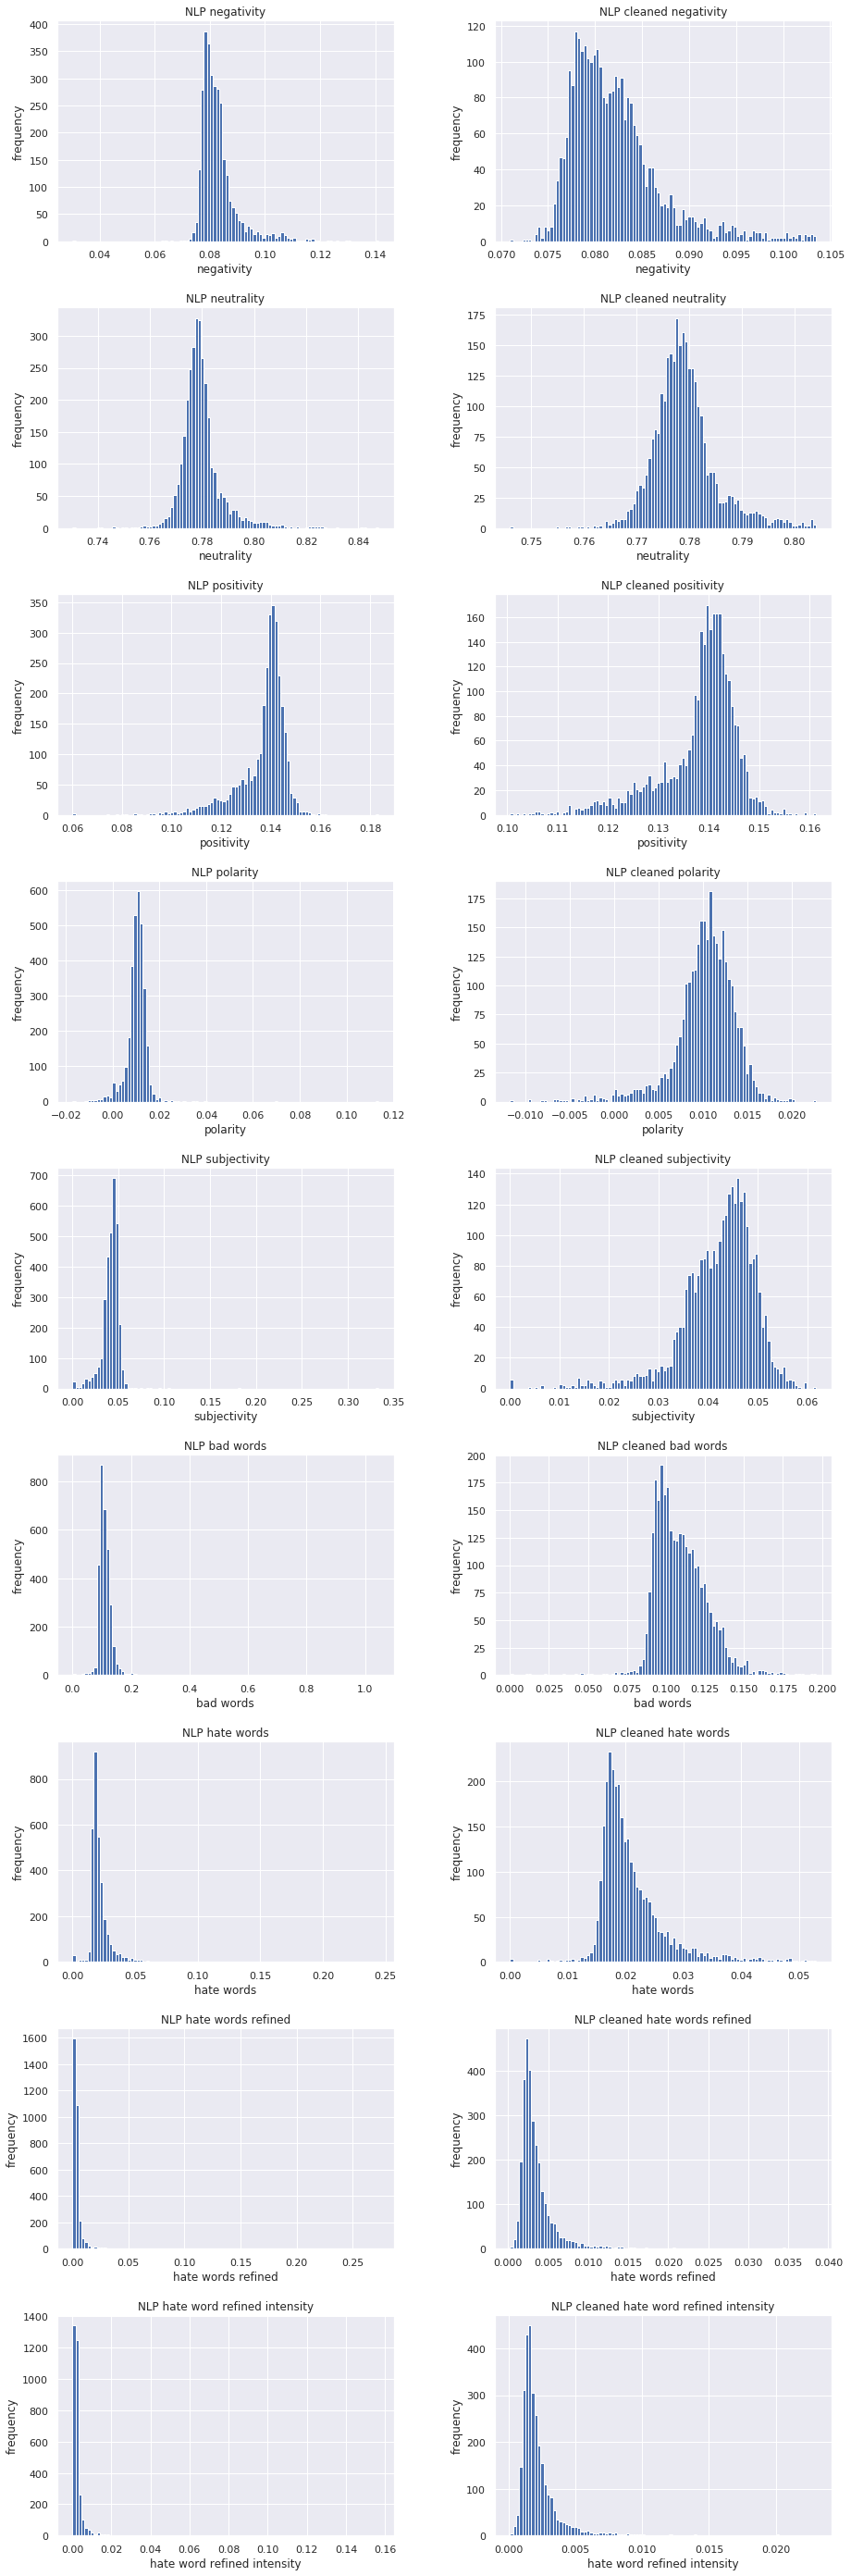

In [88]:
pc.plot_nlp_daily_distrib([nlp_n, nlp_n_cleaned], ['NLP', 'NLP cleaned'])

In [89]:
nlp_n.corr()

neg       neu       pos       pol      subj        bw  \
neg        1.000000 -0.063602 -0.611852 -0.313977 -0.340057  0.203699   
neu       -0.063602  1.000000 -0.746683 -0.134972 -0.190069 -0.014521   
pos       -0.611852 -0.746683  1.000000  0.324468  0.388174 -0.118232   
pol       -0.313977 -0.134972  0.324468  1.000000  0.642685 -0.043927   
subj      -0.340057 -0.190069  0.388174  0.642685  1.000000 -0.048077   
bw         0.203699 -0.014521 -0.118232 -0.043927 -0.048077  1.000000   
hw         0.349225  0.169222 -0.361850 -0.148082 -0.237977  0.206121   
hw_ref     0.199044  0.197443 -0.286737  0.120251 -0.018774  0.010870   
intensity  0.219414  0.198851 -0.301608  0.106186 -0.030310  0.018229   

                 hw    hw_ref  intensity  
neg        0.349225  0.199044   0.219414  
neu        0.169222  0.197443   0.198851  
pos       -0.361850 -0.286737  -0.301608  
pol       -0.148082  0.120251   0.106186  
subj      -0.237977 -0.018774  -0.030310  
bw         0.206121  0.010870   0.018229  
hw         1.000000  0.296737   0.311492  
hw_ref     0.296737  1.000000   0.996249  
intensity  0.311492  0.996249   1.000000

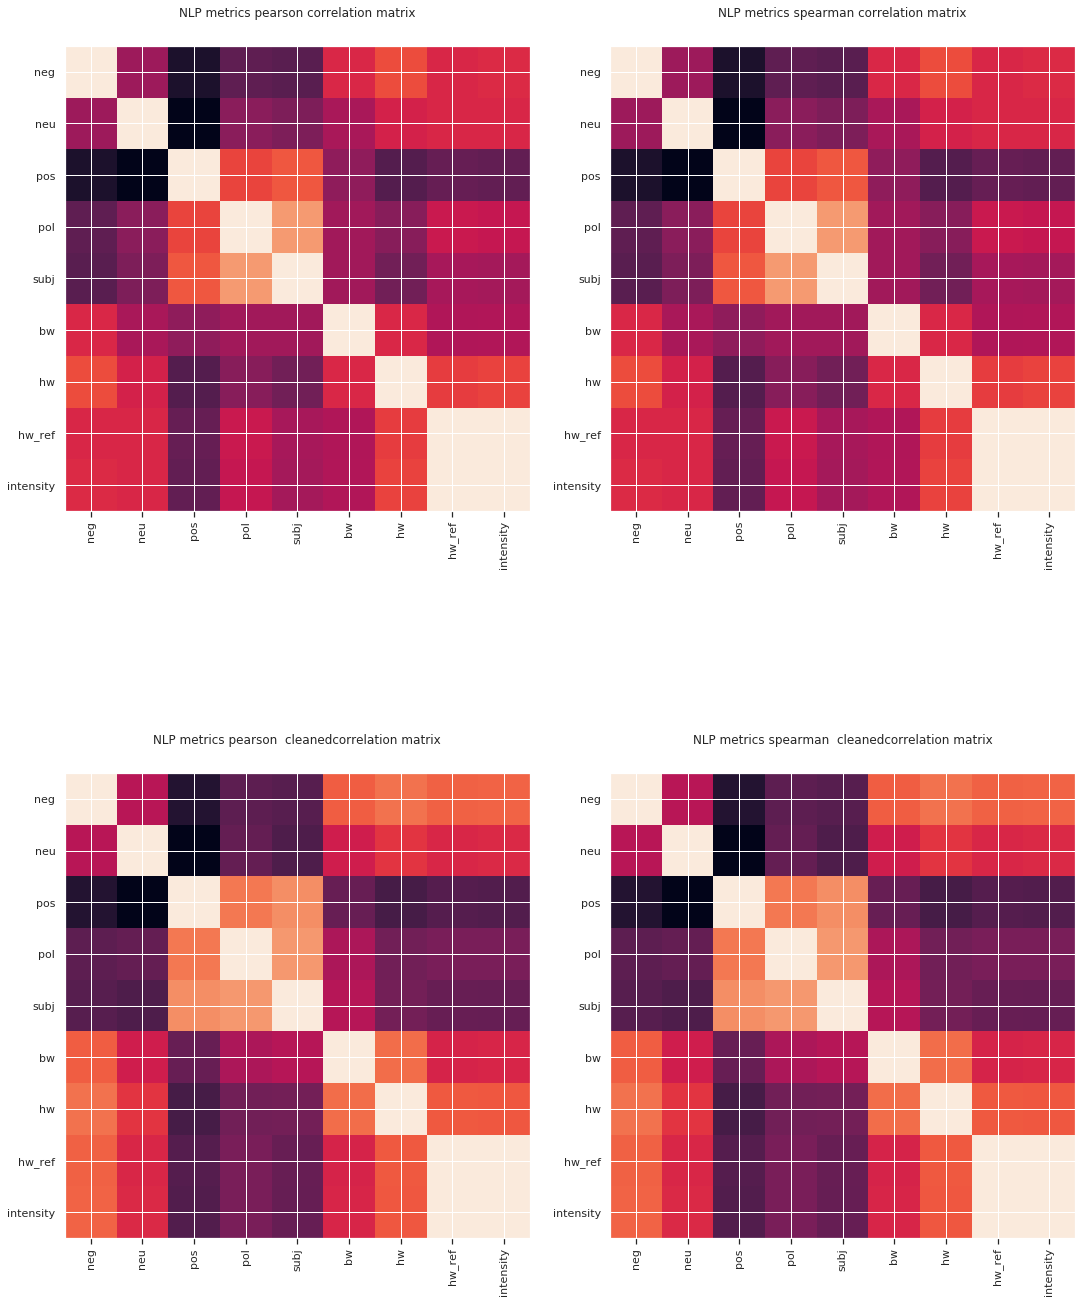

In [91]:
pc.plot_corr_mats([nlp_n, nlp_n_cleaned], 'NLP metrics', ['pearson', 'spearman'], ['', ' cleaned'])

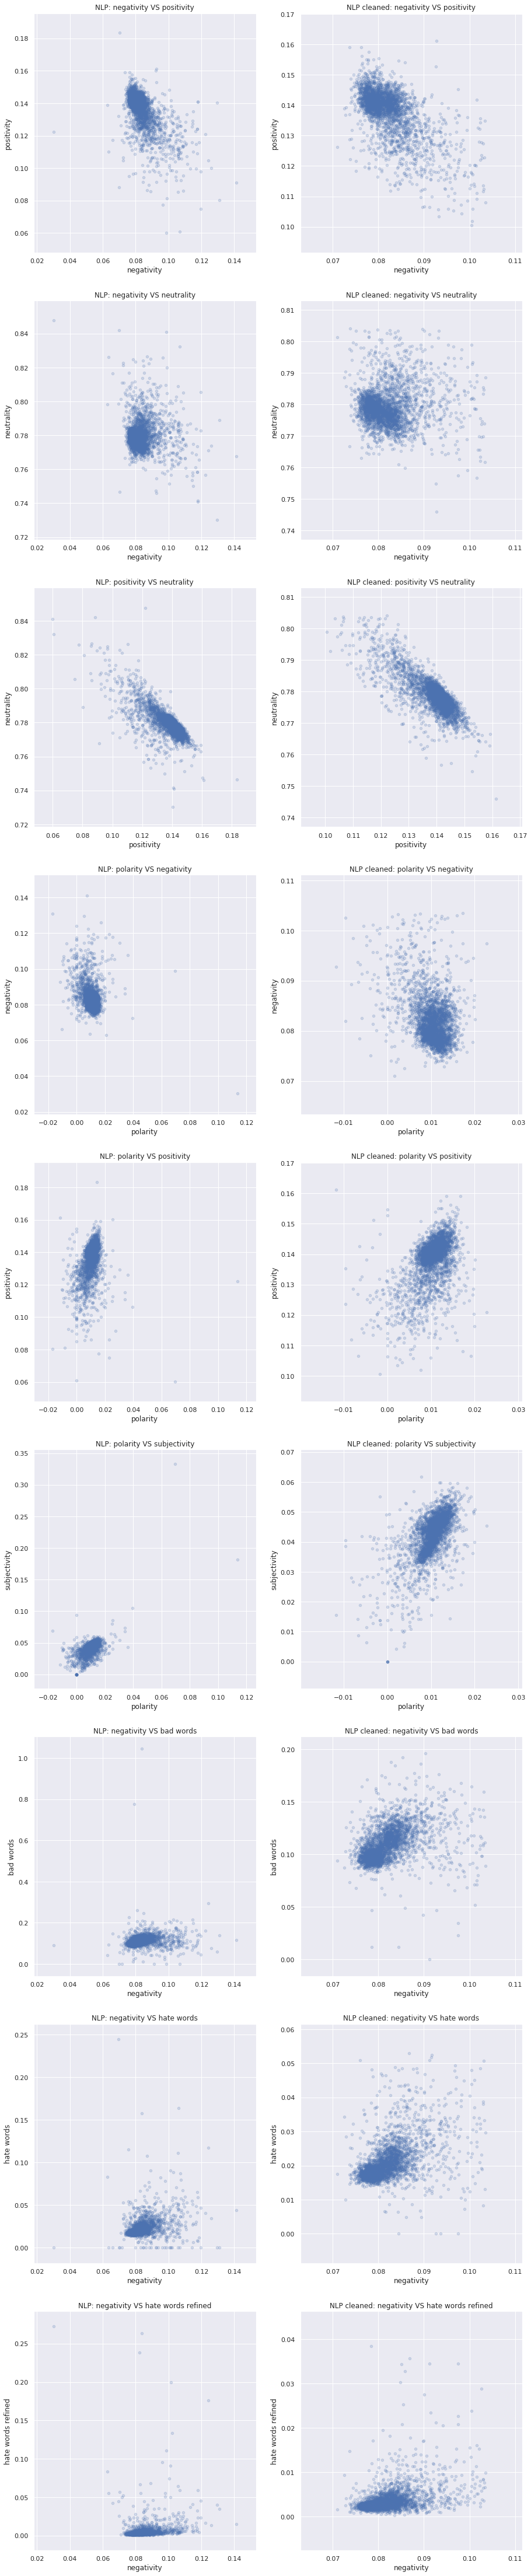

In [92]:
pc.plot_nlp_daily_metrics([nlp_n, nlp_n_cleaned], ['NLP', 'NLP cleaned'])

### Sample full messages plots

In [93]:
nlp_full = spark.read.load('../data/subreddit_nlp_full_0.001.parquet/')

In [94]:
nlp_sample = nlp_full.sample(withReplacement=False, fraction=0.4, seed=0)

In [95]:
pd_nlp_sample = nlp_sample.toPandas()

In [96]:
pd_sample = pd_nlp_sample.drop(['id', 'subreddit', 'subreddit_id', 'creation_date', 'body', 'hw_ref_intensity'], axis=1)
pd_sample.columns = ['neg', 'neu', 'pos', 'pol', 'subj', 'bw', 'hw', 'hw_ref']
pd_sample.head(5)

neg    neu    pos  pol  subj  bw  hw  hw_ref
0  0.058  0.810  0.132  0.0   0.0   0   0     0.0
1  0.000  0.927  0.073  0.0   0.0   0   0     0.0
2  0.122  0.648  0.230  0.0   0.0   0   0     0.0
3  0.000  0.691  0.309  0.0   0.0   0   0     0.0
4  0.095  0.532  0.373  0.0   0.0   0   0     0.0

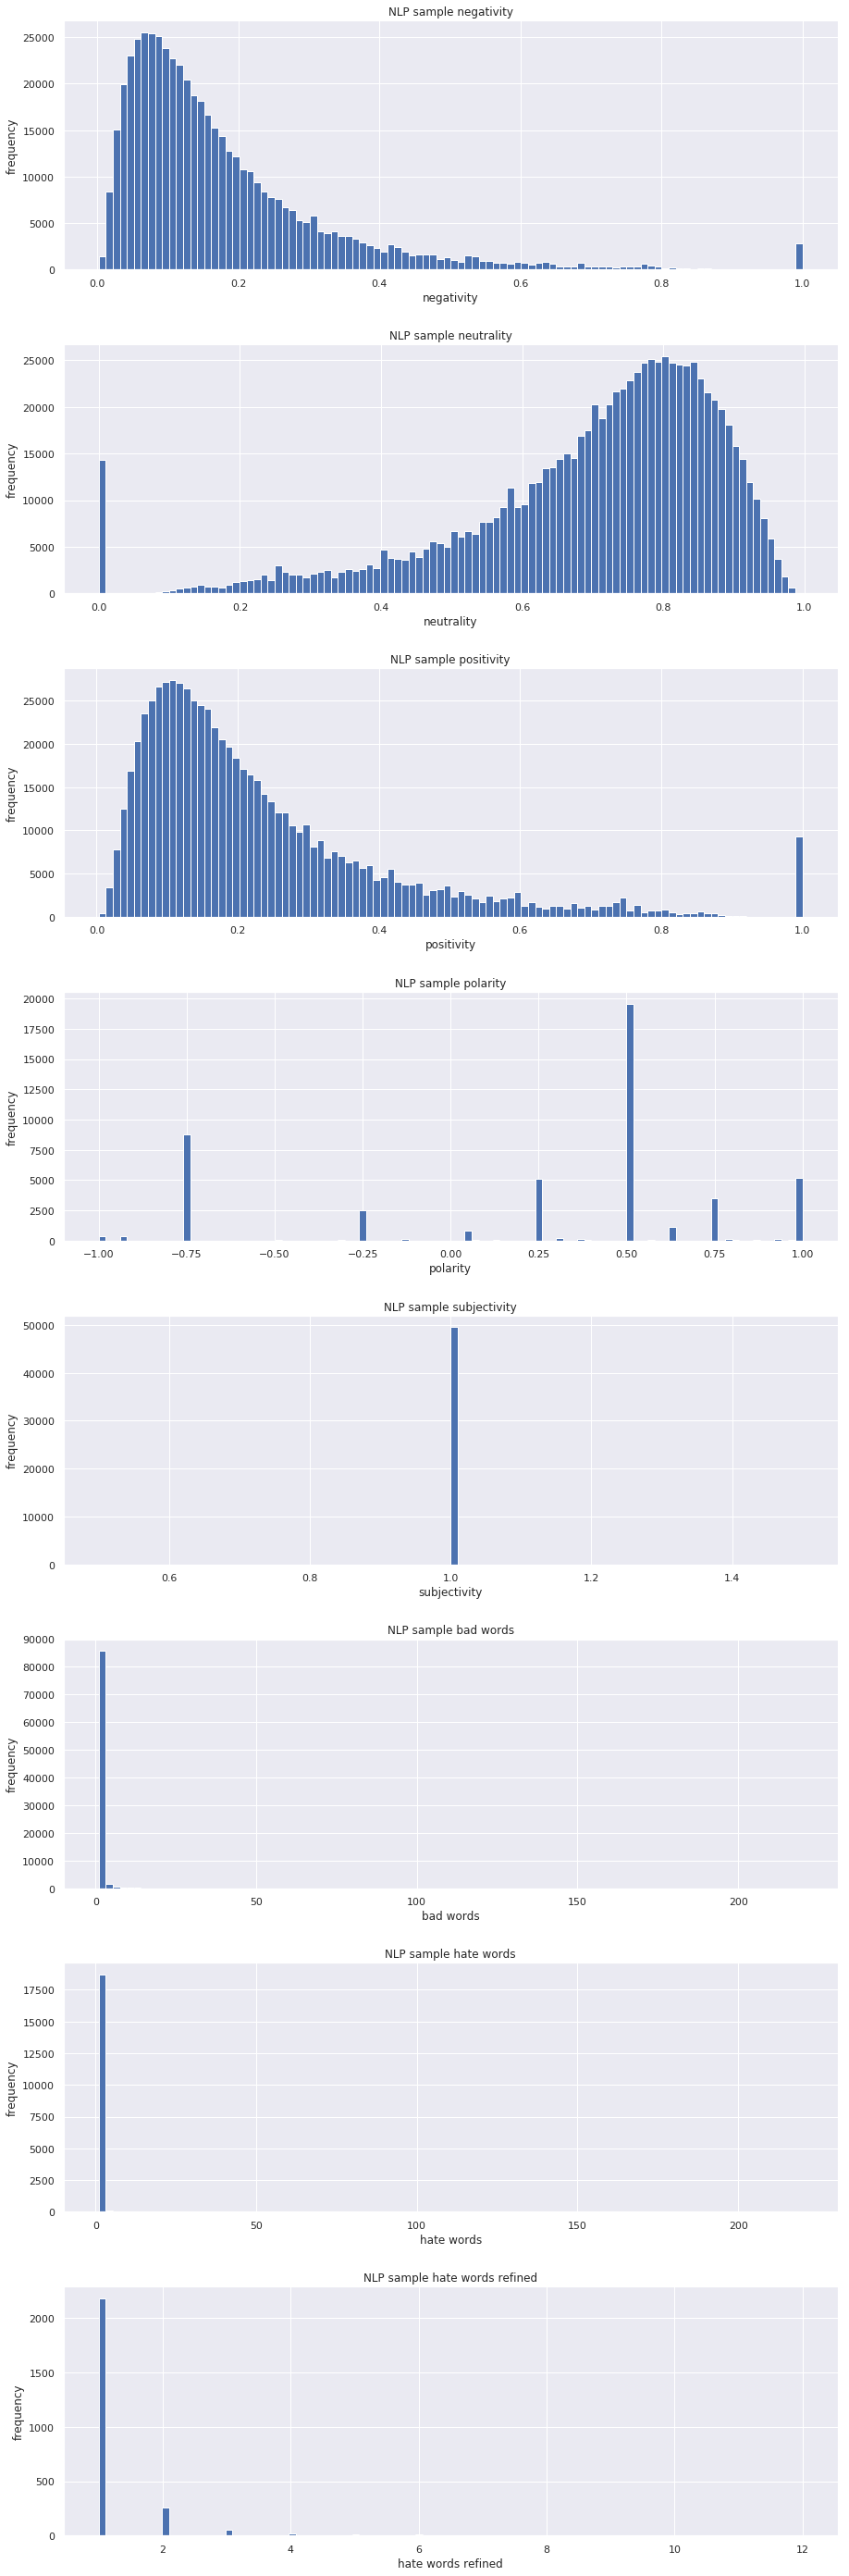

In [98]:
pc.plot_nlp_sample_distrib([pd_sample], ['NLP sample'])

### Daily metrics correlations

In [99]:
daily_agreement = spark.read.load('../data/daily_agreement.parquet').toPandas().set_index('created')
daily_metrics = spark.read.load('../data/daily_metrics.parquet').toPandas().set_index('created')
nlp_metrics = pd.read_pickle('../data/daily_nlp_metrics_merged.pkl').drop('intensity', axis=1)
nlp_metrics.columns = ['neg', 'neu', 'pos', 'pol', 'subj', 'bw', 'hw', 'hw_ref']
metrics = pd.concat([nlp_metrics, daily_agreement['agreement_factor'], daily_metrics['total_score']], axis=1, sort=True)
metrics['total_score'] = metrics['total_score'].apply(np.log)
metrics = metrics.dropna()

# Remove outliers assuming gaussian distribution
cleaned_metrics = metrics[(sp.stats.zscore(metrics) < 3).all(axis=1)]

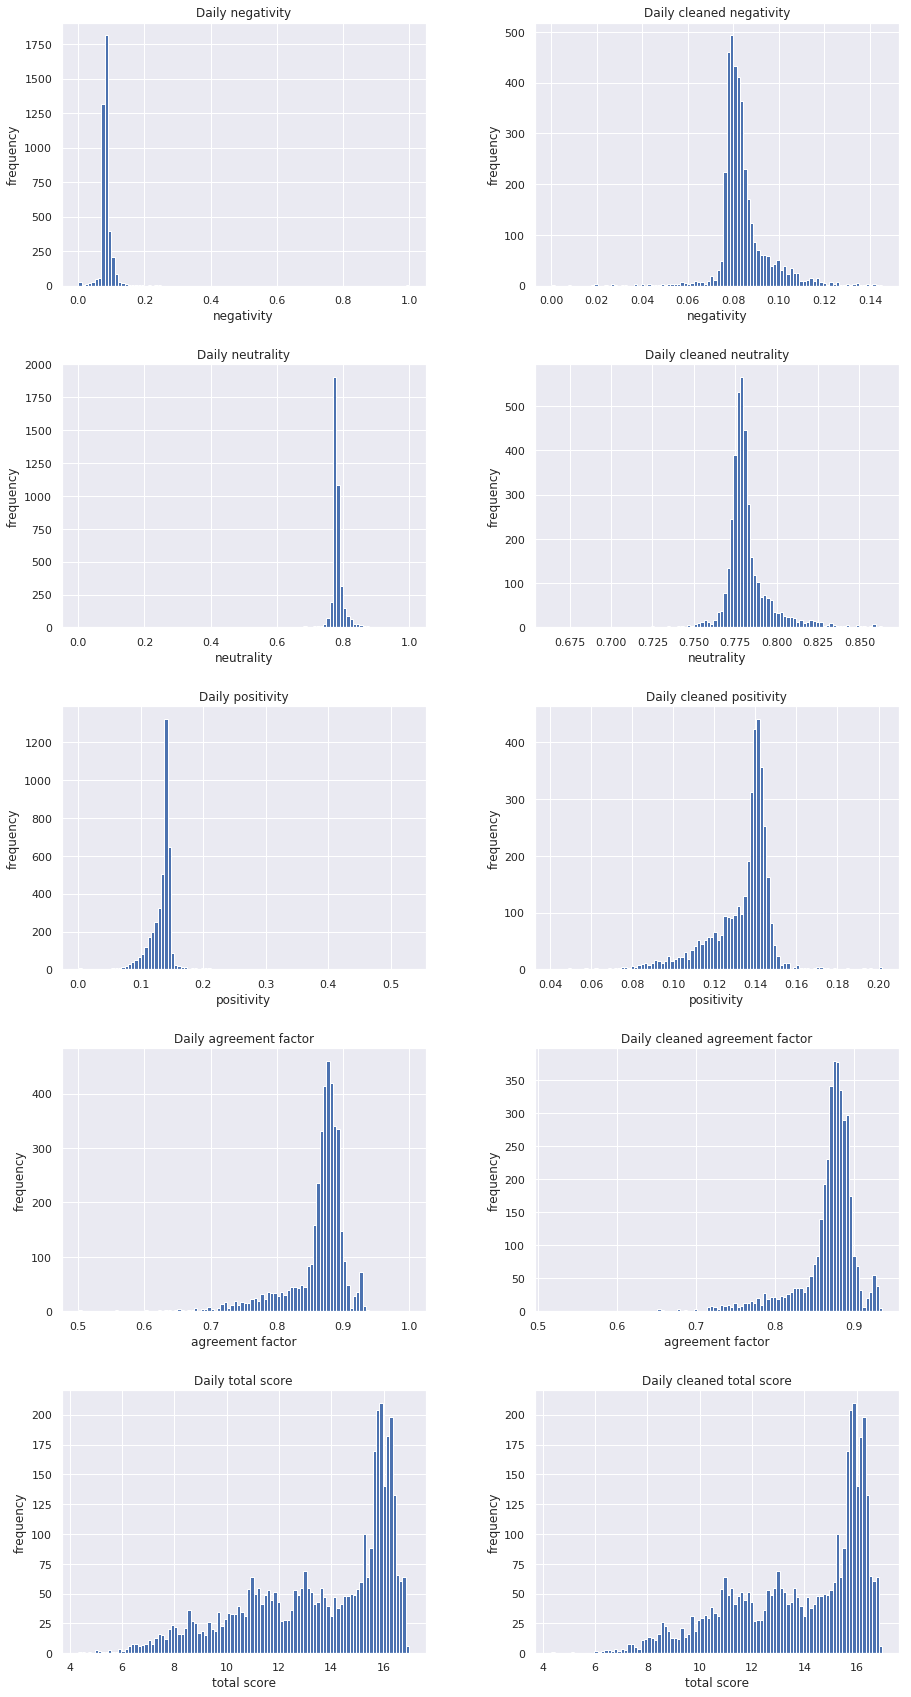

In [100]:
pc.plot_daily_distrib([metrics, cleaned_metrics], ['Daily', 'Daily cleaned'])

In [101]:
metrics.corr()

neg       neu       pos       pol      subj        bw  \
neg               1.000000 -0.571923 -0.242895 -0.057339 -0.082039  0.066601   
neu              -0.571923  1.000000 -0.650892 -0.015566 -0.019865 -0.059347   
pos              -0.242895 -0.650892  1.000000  0.073955  0.097068  0.009229   
pol              -0.057339 -0.015566  0.073955  1.000000  0.426073 -0.007662   
subj             -0.082039 -0.019865  0.097068  0.426073  1.000000 -0.040521   
bw                0.066601 -0.059347  0.009229 -0.007662 -0.040521  1.000000   
hw                0.121316  0.029203 -0.150083 -0.022199 -0.071932  0.026576   
hw_ref            0.036855  0.018231 -0.053678  0.031979 -0.000120  0.027219   
agreement_factor -0.072586 -0.129430  0.217654 -0.019518 -0.011792  0.113993   
total_score      -0.142481 -0.191520  0.353314  0.029100  0.023078  0.101956   

                        hw    hw_ref  agreement_factor  total_score  
neg               0.121316  0.036855         -0.072586    -0.142481  
neu               0.029203  0.018231         -0.129430    -0.191520  
pos              -0.150083 -0.053678          0.217654     0.353314  
pol              -0.022199  0.031979         -0.019518     0.029100  
subj             -0.071932 -0.000120         -0.011792     0.023078  
bw                0.026576  0.027219          0.113993     0.101956  
hw                1.000000  0.067604         -0.084380    -0.145998  
hw_ref            0.067604  1.000000         -0.090299    -0.086794  
agreement_factor -0.084380 -0.090299          1.000000     0.750547  
total_score      -0.145998 -0.086794          0.750547     1.000000

In [102]:
metrics.corr('spearman')

neg       neu       pos       pol      subj        bw  \
neg               1.000000 -0.149721 -0.429963 -0.199471 -0.202247  0.319839   
neu              -0.149721  1.000000 -0.693882 -0.223840 -0.302353 -0.067935   
pos              -0.429963 -0.693882  1.000000  0.372945  0.449548 -0.069688   
pol              -0.199471 -0.223840  0.372945  1.000000  0.627389  0.085903   
subj             -0.202247 -0.302353  0.449548  0.627389  1.000000  0.108474   
bw                0.319839 -0.067935 -0.069688  0.085903  0.108474  1.000000   
hw                0.350431  0.021443 -0.193423 -0.036721 -0.051836  0.433533   
hw_ref            0.142259 -0.113047  0.080570  0.111720  0.124219  0.342126   
agreement_factor -0.277655 -0.020133  0.249315  0.129255  0.090338 -0.020124   
total_score      -0.427025 -0.278636  0.567978  0.267637  0.293291 -0.087628   

                        hw    hw_ref  agreement_factor  total_score  
neg               0.350431  0.142259         -0.277655    -0.427025  
neu               0.021443 -0.113047         -0.020133    -0.278636  
pos              -0.193423  0.080570          0.249315     0.567978  
pol              -0.036721  0.111720          0.129255     0.267637  
subj             -0.051836  0.124219          0.090338     0.293291  
bw                0.433533  0.342126         -0.020124    -0.087628  
hw                1.000000  0.317579         -0.070431    -0.175831  
hw_ref            0.317579  1.000000          0.188371     0.216123  
agreement_factor -0.070431  0.188371          1.000000     0.728984  
total_score      -0.175831  0.216123          0.728984     1.000000

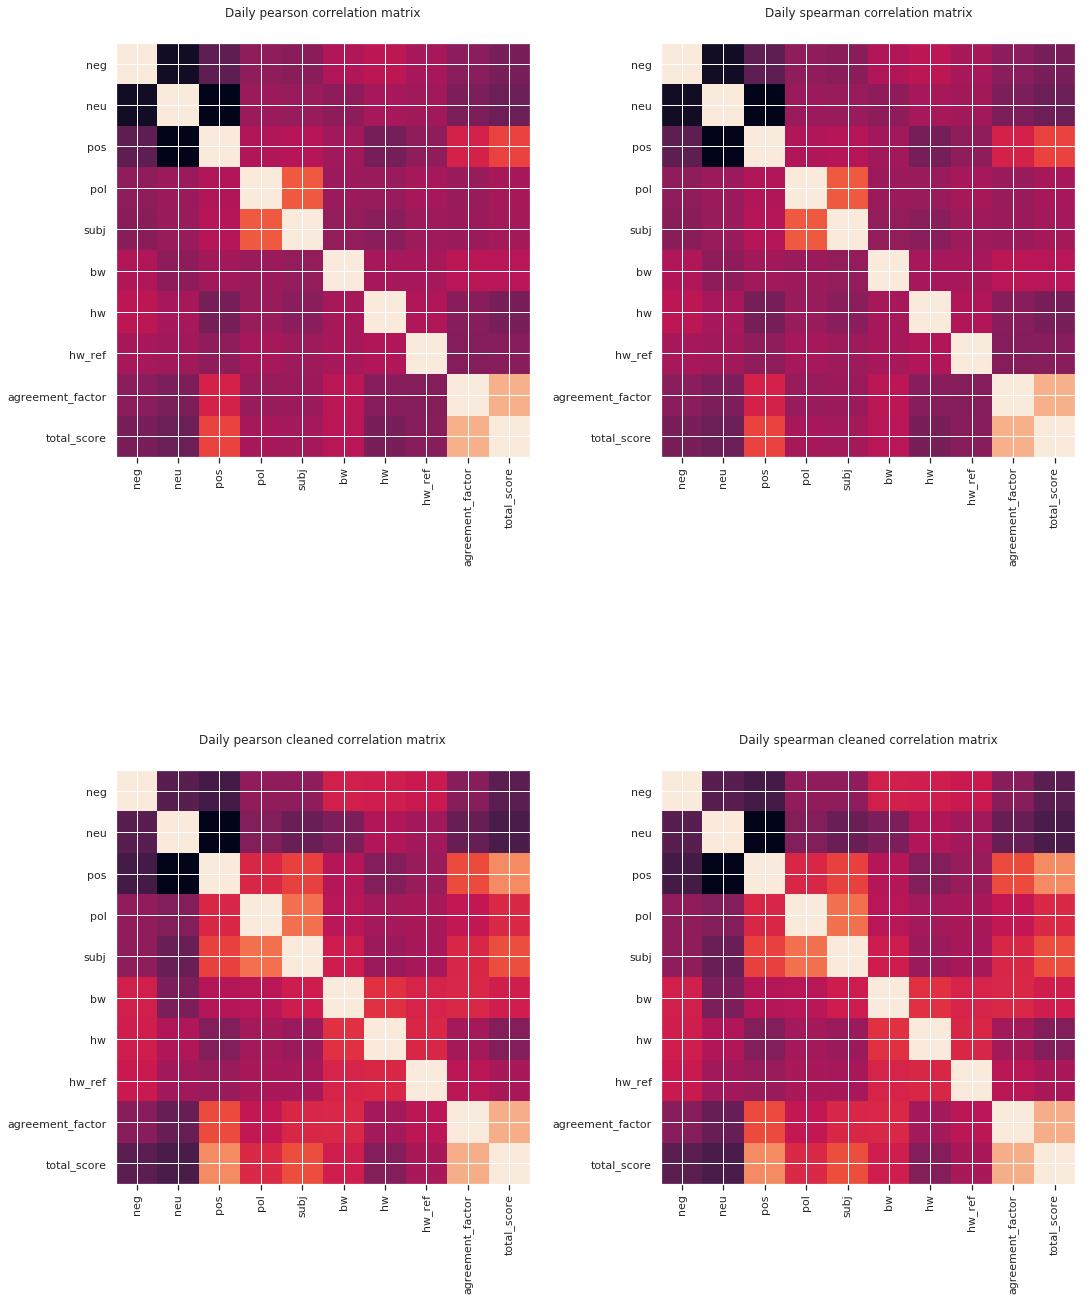

In [103]:
pc.plot_corr_mats([metrics, cleaned_metrics], 'Daily', ['pearson', 'spearman'], ['', 'cleaned '])

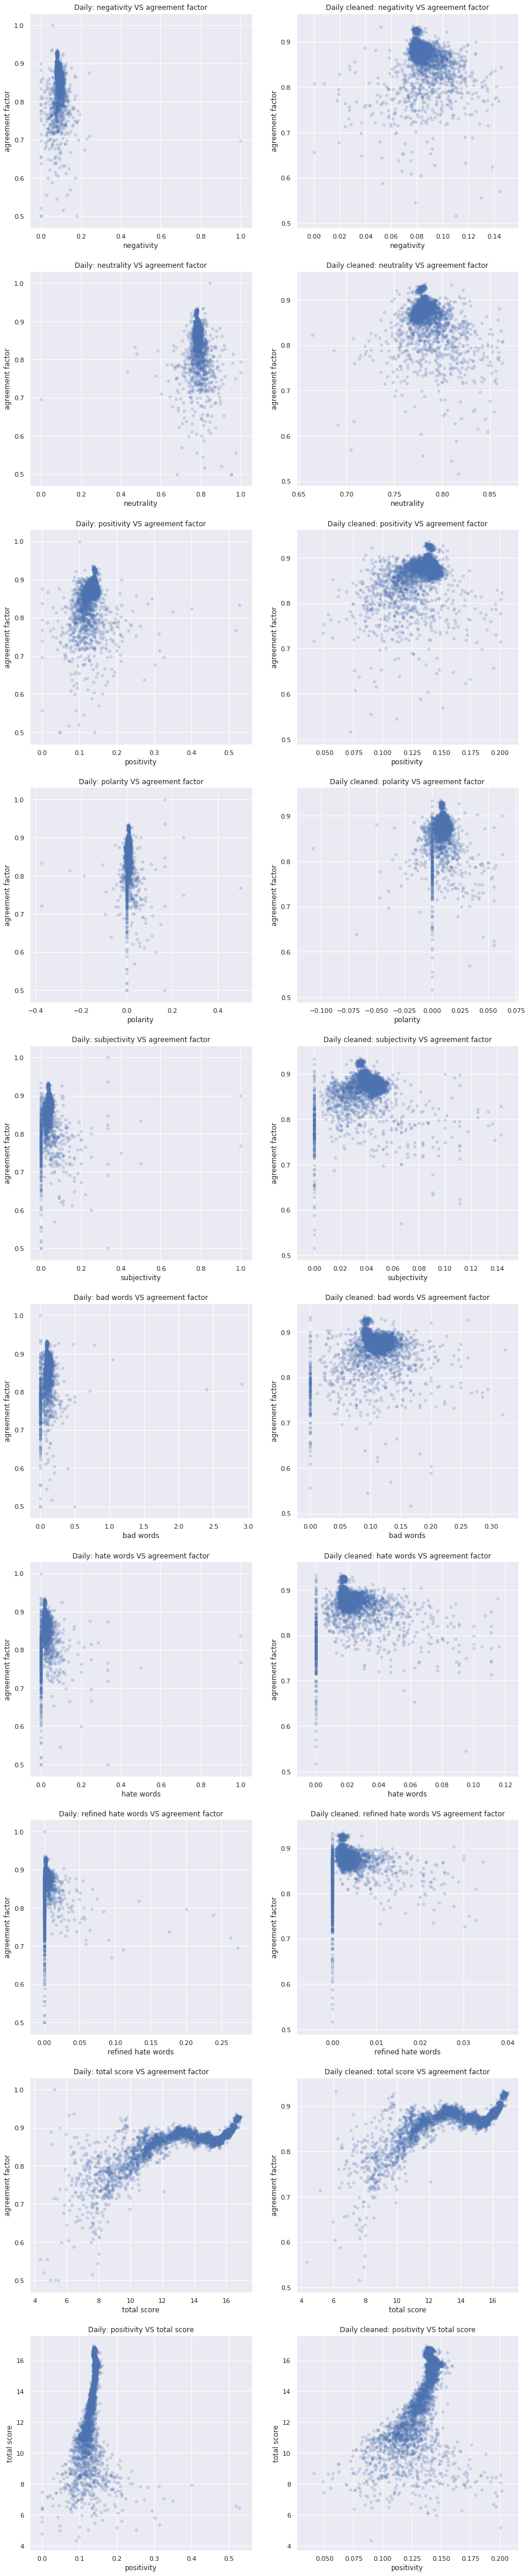

In [104]:
pc.plot_daily_metrics([metrics, cleaned_metrics], ['Daily', 'Daily cleaned'])

### Subreddits metrics correlations

In [105]:
subreddit_agreement = spark.read.load('../data/subreddit_agreement.parquet').toPandas().set_index('subreddit')
subreddit_agreement.index = subreddit_agreement.index.map(str.lower)
subreddit_nlp = spark.read.load('../data/subreddit_nlp_full_0.001.parquet').drop('id', 'subreddit_id', 'creation_date', 'body', 'hw_ref_intensity')
subreddits_names = set(subreddit_agreement.index.values)
subreddit_nlp = subreddit_nlp.filter(func.col('subreddit').isin(subreddits_names))
subreddit_to_keep = subreddit_nlp.groupBy('subreddit').count()
subreddit_nlp = subreddit_nlp.join(subreddit_to_keep, on='subreddit', how='inner')
subreddit_nlp = subreddit_nlp.filter('count > 100').drop('count')
subreddit_nlp = subreddit_nlp.groupBy('subreddit').avg()
subreddit_nlp = subreddit_nlp.toPandas().set_index('subreddit')
subreddit_nlp.columns = ['neg', 'neu', 'pos', 'pol', 'subj', 'bw', 'hw', 'hw_ref']

In [106]:
subreddit_metrics = pd.merge(subreddit_agreement, subreddit_nlp, left_index=True, right_index=True).drop(['count', 'count_pos', 'count_neg'], axis=1)

# Remove outliers assuming gaussian distribution
subreddit_metrics_cleaned = subreddit_metrics[(sp.stats.zscore(subreddit_metrics) < 3).all(axis=1)]

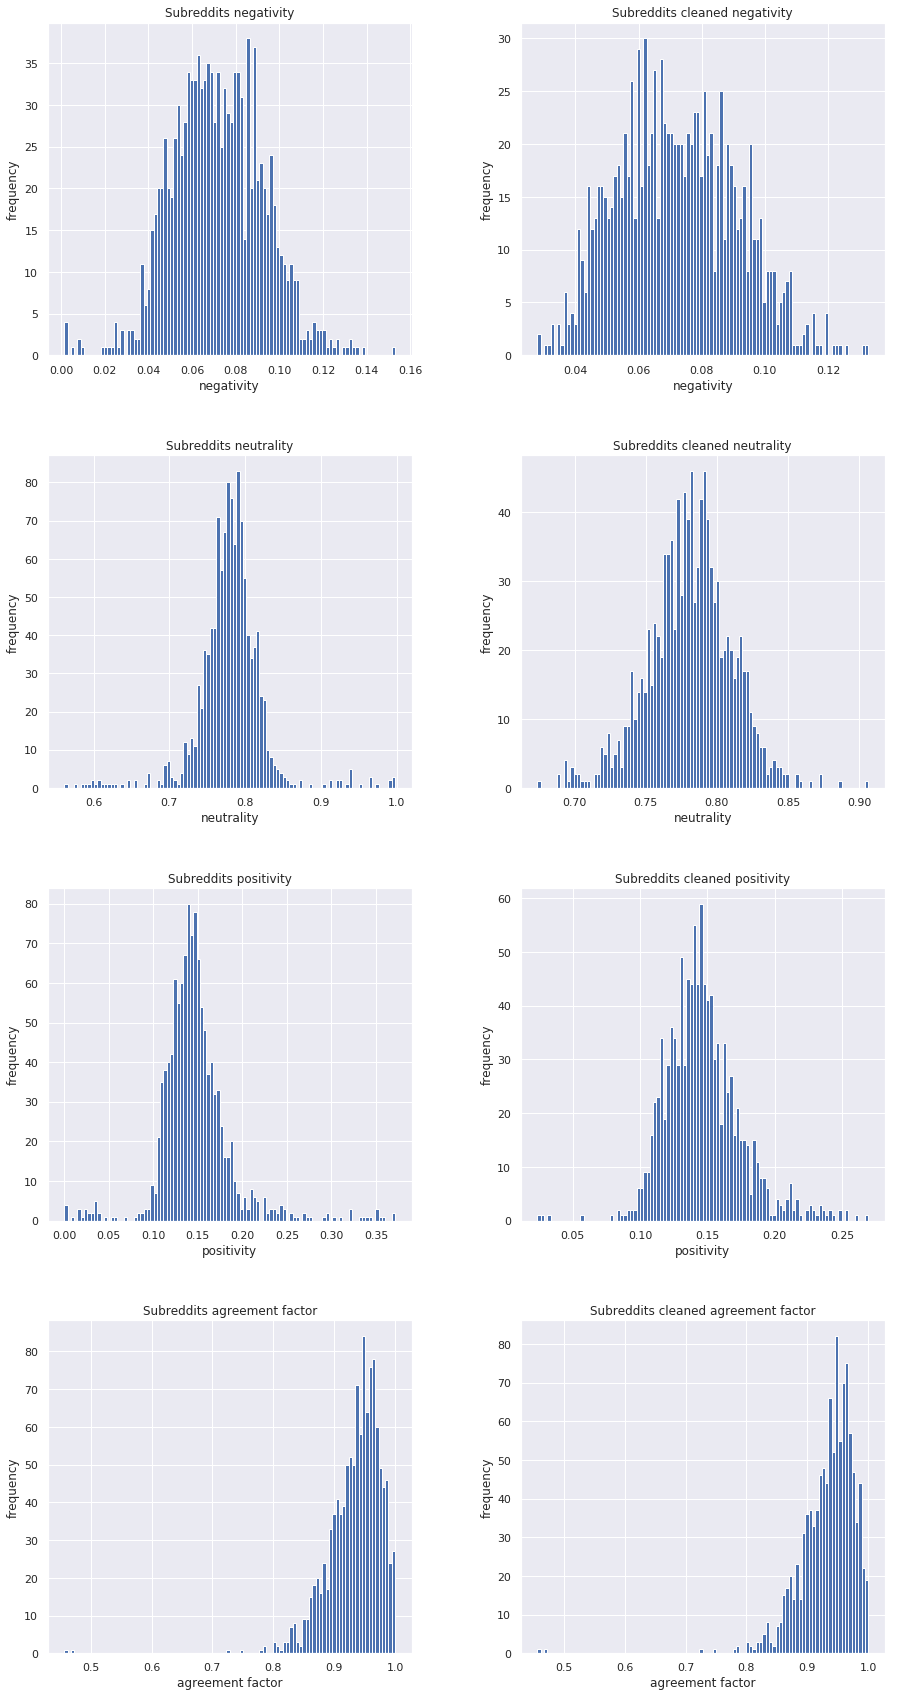

In [107]:
pc.plot_subreddit_distrib([subreddit_metrics, subreddit_metrics_cleaned], ['Subreddits', 'Subreddits cleaned'])

#### Without gaussian outliers removal

In [108]:
subreddit_metrics.corr()

agreement_factor       neg       neu       pos       pol  \
agreement_factor          1.000000 -0.097355 -0.086806  0.140337  0.050842   
neg                      -0.097355  1.000000 -0.369102 -0.120168 -0.167968   
neu                      -0.086806 -0.369102  1.000000 -0.876756 -0.357051   
pos                       0.140337 -0.120168 -0.876756  1.000000  0.469703   
pol                       0.050842 -0.167968 -0.357051  0.469703  1.000000   
subj                      0.151851 -0.318376 -0.274427  0.460468  0.119335   
bw                       -0.029750  0.396531 -0.239602  0.051261 -0.011323   
hw                       -0.024235  0.244474 -0.081713 -0.039075 -0.005887   
hw_ref                   -0.049535  0.268124 -0.025856 -0.112002 -0.073329   

                      subj        bw        hw    hw_ref  
agreement_factor  0.151851 -0.029750 -0.024235 -0.049535  
neg              -0.318376  0.396531  0.244474  0.268124  
neu              -0.274427 -0.239602 -0.081713 -0.025856  
pos               0.460468  0.051261 -0.039075 -0.112002  
pol               0.119335 -0.011323 -0.005887 -0.073329  
subj              1.000000 -0.059538 -0.042575 -0.125761  
bw               -0.059538  1.000000  0.269632  0.213173  
hw               -0.042575  0.269632  1.000000  0.304035  
hw_ref           -0.125761  0.213173  0.304035  1.000000

In [109]:
subreddit_metrics.corr('spearman')

agreement_factor       neg       neu       pos       pol  \
agreement_factor          1.000000 -0.073074 -0.169091  0.202652  0.123544   
neg                      -0.073074  1.000000 -0.394236 -0.229072 -0.353398   
neu                      -0.169091 -0.394236  1.000000 -0.737327 -0.208060   
pos                       0.202652 -0.229072 -0.737327  1.000000  0.463369   
pol                       0.123544 -0.353398 -0.208060  0.463369  1.000000   
subj                      0.147115 -0.388739 -0.209419  0.476416  0.747895   
bw                       -0.095140  0.631038 -0.320013 -0.089957 -0.213199   
hw                       -0.080349  0.334252 -0.086328 -0.166877 -0.116751   
hw_ref                   -0.143097  0.324414 -0.029011 -0.200538 -0.133625   

                      subj        bw        hw    hw_ref  
agreement_factor  0.147115 -0.095140 -0.080349 -0.143097  
neg              -0.388739  0.631038  0.334252  0.324414  
neu              -0.209419 -0.320013 -0.086328 -0.029011  
pos               0.476416 -0.089957 -0.166877 -0.200538  
pol               0.747895 -0.213199 -0.116751 -0.133625  
subj              1.000000 -0.275678 -0.180303 -0.180054  
bw               -0.275678  1.000000  0.402802  0.359463  
hw               -0.180303  0.402802  1.000000  0.371331  
hw_ref           -0.180054  0.359463  0.371331  1.000000

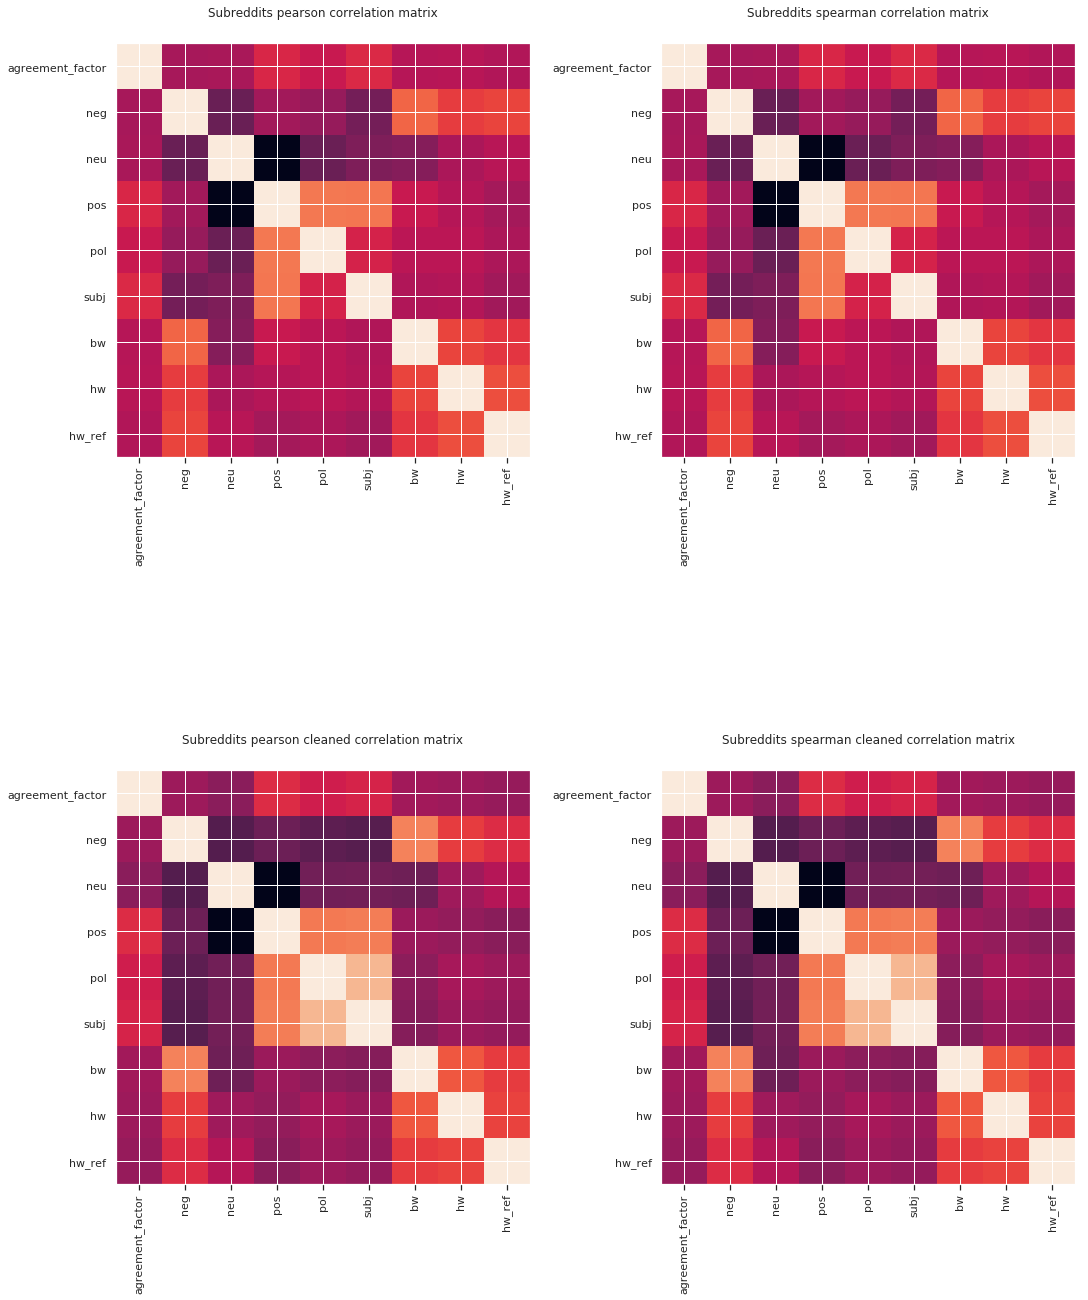

In [110]:
pc.plot_corr_mats([subreddit_metrics, subreddit_metrics_cleaned], 'Subreddits', ['pearson', 'spearman'], ['', 'cleaned '])

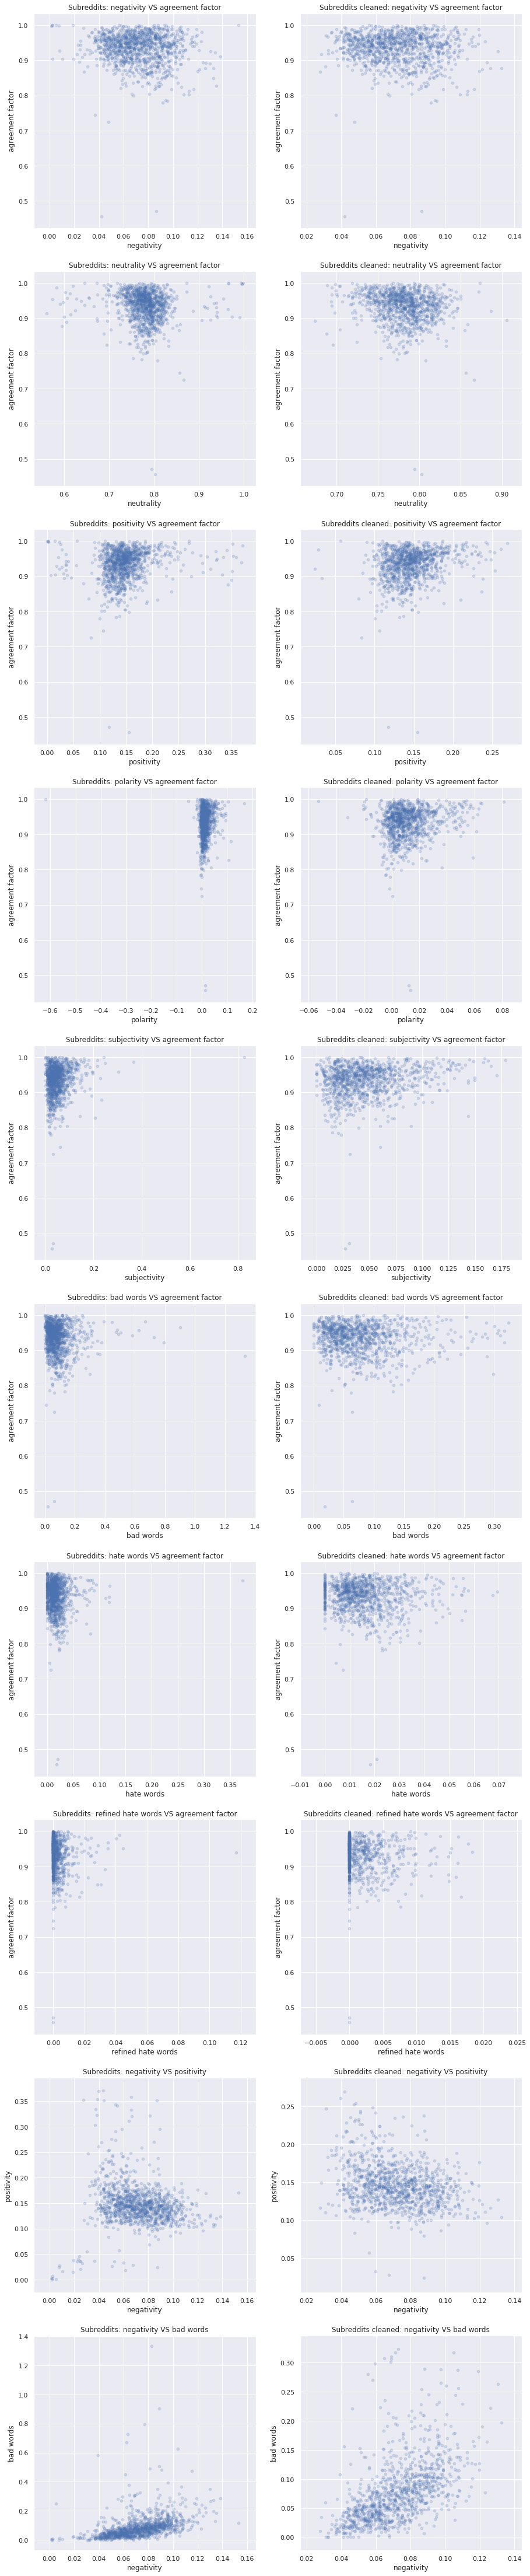

In [111]:
pc.plot_subreddit_metrics([subreddit_metrics, subreddit_metrics_cleaned], ['Subreddits', 'Subreddits cleaned'])